In [1]:
import jax
import jax.numpy as jnp
from jax import random, vmap, grad, jit, jacrev
from functools import partial
import optax
import flax
import flax.linen as nn
from flax.training import checkpoints, train_state
from tqdm import trange
import matplotlib.pyplot as plt
import scipy.io
import time
import numpy as np
import csv

jax.config.update("jax_enable_x64", True)

print("JAX devices:", jax.devices())
print(f"JAX backend: {jax.default_backend()}")

JAX devices: [CudaDevice(id=0)]
JAX backend: gpu


W1218 21:50:29.461242  100486 cuda_executor.cc:1802] GPU interconnect information not available: INTERNAL: NVML doesn't support extracting fabric info or NVLink is not used by the device.
W1218 21:50:29.463794   96376 cuda_executor.cc:1802] GPU interconnect information not available: INTERNAL: NVML doesn't support extracting fabric info or NVLink is not used by the device.


In [ ]:

def compute_ntk_diagonal_simple(model, params, config):
    """Simplified diagonal NTK using mean squared gradients."""
    n_samples = config.get('ntk_samples', 64)
    key = jax.random.PRNGKey(int(time.time()) % 10000)
    
    key, k1 = jax.random.split(key)
    x_ic = jax.random.uniform(k1, (n_samples,), minval=-1.0, maxval=1.0)
    t_ic = jnp.zeros(n_samples)
    
    key, k2 = jax.random.split(key)
    t_bc = jax.random.uniform(k2, (n_samples,), minval=0.0, maxval=1.0)
    
    key, k3, k4 = jax.random.split(key, 3)
    t_res = jax.random.uniform(k3, (n_samples,), minval=0.0, maxval=1.0)
    x_res = jax.random.uniform(k4, (n_samples,), minval=-1.0, maxval=1.0)
    
    def u_scalar(p, t, x):
        y = model.apply(p, jnp.array([[t, x]]))
        return y[0, 0]
    
    def mean_sq_grad(t_pts, x_pts):
        def sq_grad_norm(t, x):
            g = grad(u_scalar)(params, t, x)
            return sum(jnp.sum(leaf ** 2) for leaf in jax.tree_util.tree_leaves(g))
        return jnp.mean(vmap(sq_grad_norm)(t_pts, x_pts))
    
    trace_ic = mean_sq_grad(t_ic, x_ic)
    trace_bc_l = mean_sq_grad(t_bc, jnp.full_like(t_bc, -1.0))
    trace_bc_r = mean_sq_grad(t_bc, jnp.full_like(t_bc, 1.0))
    trace_bc = (trace_bc_l + trace_bc_r) / 2
    trace_res = mean_sq_grad(t_res, x_res)
    
    eps = 1e-10
    traces = jnp.array([trace_ic, trace_bc, trace_res])
    max_trace = jnp.max(traces)
    
    w_ic = jnp.clip(max_trace / (trace_ic + eps), 0.1, 10.0)
    w_bc = jnp.clip(max_trace / (trace_bc + eps), 0.1, 10.0)
    w_res = jnp.clip(max_trace / (trace_res + eps), 0.1, 10.0)
    
    return {
        'ic': float(jax.lax.stop_gradient(w_ic)),
        'bc': float(jax.lax.stop_gradient(w_bc)),
        'res': float(jax.lax.stop_gradient(w_res)),
    }

In [ ]:


class MLP(nn.Module):
    """Simple MLP for D-FactNET coefficient loading."""
    num_layers: int = 6
    hidden_dim: int = 128
    output_dim: int = 12
    activation: callable = nn.gelu

    @nn.compact
    def __call__(self, x):
        for _ in range(self.num_layers):
            x = nn.Dense(self.hidden_dim)(x)
            x = self.activation(x)
        x = nn.Dense(self.output_dim)(x)
        return x


class MLPFactorizer:
    """Wrapper for loading D-FactNET checkpoints."""
    
    def __init__(self, arch, skip_init=False):
        self.model = arch
        self.params = None if skip_init else self.model.init(
            random.PRNGKey(1), jnp.array([[1.0, 1.0, 1.0]])
        )

    def load_model(self, ckpt_dir='checkpoints'):
        """Load D-FactNET coefficients from checkpoint."""
        checkpoint_data = {
            'params': self.params or {},
            'coefficients': jnp.zeros((3, 5))
        }
        restored = checkpoints.restore_checkpoint(
            ckpt_dir=ckpt_dir,
            target=checkpoint_data,
            step=None
        )
        self.params = restored['params']
        return restored['coefficients']

In [ ]:
#adapted from https://github.com/PredictiveIntelligenceLab/jaxpi.git
class FourierEmbedding(nn.Module):
    """Random Fourier feature embedding."""
    embed_scale: float
    embed_dim: int

    @nn.compact
    def __call__(self, x):
        kernel = self.param(
            "kernel",
            nn.initializers.normal(stddev=self.embed_scale),
            (x.shape[-1], self.embed_dim // 2)
        )
        proj = jnp.dot(x, kernel)
        return jnp.concatenate([jnp.cos(proj), jnp.sin(proj)], axis=-1)


class PIModifiedBottleneck(nn.Module):
    """Physics-Informed Modified Bottleneck block with gating."""
    hidden_dim: int
    activation: callable
    alpha_init: float = 0.0

    @nn.compact
    def __call__(self, x, u, v):
        identity = x
        f = self.activation(nn.Dense(self.hidden_dim)(x))
        z1 = f * u + (1 - f) * v
        g = self.activation(nn.Dense(self.hidden_dim)(z1))
        z2 = g * u + (1 - g) * v
        h = self.activation(nn.Dense(identity.shape[-1])(z2))
        alpha = self.param('alpha', nn.initializers.constant(self.alpha_init), (1,))
        return alpha * h + (1 - alpha) * identity


class PirateNet(nn.Module):
    """PirateNet architecture with Fourier embeddings and gated residual blocks."""
    num_layers: int
    embed_dim: int
    hidden_dim: int
    out_dim: int
    activation: callable
    use_fourier: bool = True
    fourier_scale: float = 2.0
    alpha_init: float = 0.0

    @nn.compact
    def __call__(self, x):
        if self.use_fourier:
            x_embed = FourierEmbedding(embed_scale=self.fourier_scale, embed_dim=self.embed_dim)(x)
        else:
            x_embed = self.activation(nn.Dense(self.embed_dim)(x))

        u = self.activation(nn.Dense(features=self.hidden_dim)(x_embed))
        v = self.activation(nn.Dense(features=self.hidden_dim)(x_embed))

        z = x_embed
        for i in range(self.num_layers):
            z = PIModifiedBottleneck(
                hidden_dim=self.hidden_dim,
                activation=self.activation,
                alpha_init=self.alpha_init,
                name=f"bottleneck_{i}"
            )(z, u, v)

        y = nn.Dense(features=self.out_dim, name="final_output")(z)
        return y

In [ ]:

class Phase1DataGenerator:
    """Phase 1: DATA loss only."""
    def __init__(self, batch_config, data_coords, u_data):
        self.batch_size = batch_config['data']
        self.t_data, self.x_data = data_coords
        self.u_data = u_data
        self.num_t, self.num_x = self.u_data.shape
        self.key = jax.random.PRNGKey(0)

    def __iter__(self):
        return self

    def __next__(self):
        self.key, key1, key2 = jax.random.split(self.key, 3)
        idx_t = jax.random.randint(key1, (self.batch_size,), 0, self.num_t)
        idx_x = jax.random.randint(key2, (self.batch_size,), 0, self.num_x)
        return {
            "t_data": self.t_data[idx_t],
            "x_data": self.x_data[idx_x],
            "u_data": self.u_data[idx_t, idx_x],
        }


class Phase2DataGenerator:
    """Phase 2: DATA + IC + BC."""
    def __init__(self, batch_config, data_coords, u_data):
        self.batch_config = batch_config
        self.t_data, self.x_data = data_coords
        self.u_data = u_data
        self.num_t, self.num_x = self.u_data.shape
        self.u0 = self.u_data[0, :]
        self.x_data_arr = jnp.array(self.x_data)
        self.key = jax.random.PRNGKey(1)

    def __iter__(self):
        return self

    def __next__(self):
        self.key, k1, k2, k3, k4 = jax.random.split(self.key, 5)
        idx_t = jax.random.randint(k1, (self.batch_config['data'],), 0, self.num_t)
        idx_x = jax.random.randint(k2, (self.batch_config['data'],), 0, self.num_x)
        ic_idx = jax.random.randint(k3, (self.batch_config['ics'],), 0, self.num_x)
        return {
            "t_data": self.t_data[idx_t],
            "x_data": self.x_data[idx_x],
            "u_data": self.u_data[idx_t, idx_x],
            "t_bc": jax.random.uniform(k4, (self.batch_config['bc'],), minval=0.0, maxval=1.0),
            "x_ic": self.x_data_arr[ic_idx],
            "u_ic": self.u0[ic_idx],
        }


class Phase3DataGenerator:
    """Phase 3: DATA (decaying) + IC + BC + RES."""
    def __init__(self, batch_config, data_coords, u_data):
        self.batch_config = batch_config
        self.t_data, self.x_data = data_coords
        self.u_data = u_data
        self.num_t, self.num_x = self.u_data.shape
        self.u0 = self.u_data[0, :]
        self.x_data_arr = jnp.array(self.x_data)
        self.n_res = batch_config['residual']
        self.key = jax.random.PRNGKey(2)

    def __iter__(self):
        return self

    def __next__(self):
        self.key, k1, k2, k3, k4, k5, k6 = jax.random.split(self.key, 7)
        idx_t = jax.random.randint(k1, (self.batch_config['data'],), 0, self.num_t)
        idx_x = jax.random.randint(k2, (self.batch_config['data'],), 0, self.num_x)
        ic_idx = jax.random.randint(k3, (self.batch_config['ics'],), 0, self.num_x)
        t_base = jnp.linspace(0.0, 1.0, self.n_res)
        t_jitter = jax.random.uniform(k5, (self.n_res,), minval=-0.5/self.n_res, maxval=0.5/self.n_res)
        return {
            "t_data": self.t_data[idx_t],
            "x_data": self.x_data[idx_x],
            "u_data": self.u_data[idx_t, idx_x],
            "t_bc": jax.random.uniform(k4, (self.batch_config['bc'],), minval=0.0, maxval=1.0),
            "x_ic": self.x_data_arr[ic_idx],
            "u_ic": self.u0[ic_idx],
            "t_res": jnp.clip(t_base + t_jitter, 0.0, 1.0),
            "x_res": jax.random.uniform(k6, (self.n_res,), minval=-1.0, maxval=1.0),
        }


class TrainState(train_state.TrainState):
    """Simple training state."""
    pass


class CSVLogger:
    """CSV logger for loss tracking."""
    def __init__(self, filename, fieldnames):
        self.filename = filename
        self.fieldnames = fieldnames
        with open(filename, 'w', newline='') as f:
            writer = csv.DictWriter(f, fieldnames=fieldnames)
            writer.writeheader()
    
    def log(self, row_dict):
        with open(self.filename, 'a', newline='') as f:
            writer = csv.DictWriter(f, fieldnames=self.fieldnames)
            writer.writerow(row_dict)

In [6]:
# ==========================================
# Curriculum PINN Trainer
# ==========================================

class CurriculumPINNTrainer:
    """Curriculum PINN trainer with three phases."""
    
    def __init__(self, config, u0, x_star):
        self.config = config
        self.u0 = u0
        self.x_star = x_star
        self.pde_type = config.get('pde_type', 'unknown')

        self.model = PirateNet(
            num_layers=config['num_layers'],
            embed_dim=config['embed_dim'],
            hidden_dim=config['hidden_dim'],
            out_dim=1,
            activation=nn.tanh,
            use_fourier=config['use_fourier'],
            fourier_scale=config['fourier_scale'],
            alpha_init=config['alpha_init']
        )
        
        params = self.model.init(jax.random.PRNGKey(42), jnp.ones((1, 2)))
        tx = optax.inject_hyperparams(optax.adam)(learning_rate=config['lr_schedule']['phase1']['lr_init'])
        self.state = TrainState.create(apply_fn=self.model.apply, params=flax.core.freeze(params), tx=tx)

        self.current_phase = 1
        self.ntk_weights = {'ic': 1.0, 'bc': 1.0, 'res': 1.0}
        self.loss_log = []
        self.phase1_end = config['phase1_steps']
        self.phase2_end = config['phase1_steps'] + config['phase2_steps']
        self.csv_logger = CSVLogger(
            config['csv_filename'],
            ['step', 'loss', 'lr', 'data', 'ic', 'bc', 'res', 'w_data', 'w_ic', 'w_bc', 'w_res']
        )
        
        # Store IC/BC/PDE functions
        self.ic_fn = None
        self.bc_fn = None
        self.pde_fn = None

    def set_pde_functions(self, ic_fn, bc_fn, pde_fn):
        """Set IC, BC, and PDE residual functions."""
        self.ic_fn = ic_fn
        self.bc_fn = bc_fn
        self.pde_fn = pde_fn

    def _compute_lr(self, global_step):
        cfg = self.config
        lr_cfg = cfg['lr_schedule']
        if global_step < self.phase1_end:
            phase_cfg = lr_cfg['phase1']
            lr_init = phase_cfg['lr_init']
            steps_in_phase = global_step
        elif global_step < self.phase2_end:
            phase_cfg = lr_cfg['phase2']
            lr_init = lr_cfg['phase1']['lr_end']
            steps_in_phase = global_step - self.phase1_end
        else:
            phase_cfg = lr_cfg['phase3']
            lr_init = lr_cfg['phase2']['lr_end']
            steps_in_phase = global_step - self.phase2_end

        lr_peak = phase_cfg['lr_peak']
        lr_end = phase_cfg['lr_end']
        warmup_steps = phase_cfg['warmup_steps']
        decay_steps = phase_cfg['decay_steps']
        decay_rate = phase_cfg['decay_rate']

        if steps_in_phase < warmup_steps:
            progress = steps_in_phase / warmup_steps
            lr = lr_init + progress * (lr_peak - lr_init)
        else:
            decay_progress = steps_in_phase - warmup_steps
            lr = lr_end + (lr_peak - lr_end) * (decay_rate ** (decay_progress / decay_steps))
            lr = max(lr, lr_end)
        return lr

    def _cubic_warmup(self, progress):
        return jnp.clip(progress, 0.0, 1.0) ** 3

    def _cubic_decay(self, progress):
        return (1.0 - jnp.clip(progress, 0.0, 1.0)) ** 3

    def _make_loss_fn_phase1(self):
        apply_fn = self.model.apply
        def loss_fn(params, t_data, x_data, u_data):
            inputs = jnp.stack([t_data, x_data], axis=-1)
            y = apply_fn(params, inputs)
            data_loss = jnp.mean((y[:, 0] - u_data) ** 2)
            return data_loss, {'data': data_loss, 'ic': 0.0, 'bc': 0.0, 'res': 0.0}
        return loss_fn

    def _make_step_fn_phase1(self):
        loss_fn = self._make_loss_fn_phase1()
        @jax.jit
        def step(state, t_data, x_data, u_data):
            (loss, losses), grads = jax.value_and_grad(loss_fn, has_aux=True)(state.params, t_data, x_data, u_data)
            state = state.apply_gradients(grads=grads)
            grad_norm = jnp.sqrt(sum(jnp.sum(g**2) for g in jax.tree_util.tree_leaves(grads)))
            return state, loss, losses, grad_norm
        return step

    def _make_loss_fn_phase2(self):
        apply_fn = self.model.apply
        def loss_fn(params, t_data, x_data, u_data, t_bc, x_ic, u_ic, w_ic, w_bc):
            inputs_data = jnp.stack([t_data, x_data], axis=-1)
            y_data = apply_fn(params, inputs_data)
            data_loss = jnp.mean((y_data[:, 0] - u_data) ** 2)

            t_ic_zeros = jnp.zeros_like(x_ic)
            inputs_ic = jnp.stack([t_ic_zeros, x_ic], axis=-1)
            y_ic = apply_fn(params, inputs_ic)
            u_ic_true = self.ic_fn(x_ic)
            ic_loss = jnp.mean((y_ic[:, 0] - u_ic_true) ** 2)

            def u_scalar(p, t, x):
                y = apply_fn(p, jnp.array([[t, x]]))
                return y[0, 0]
            bc_loss = jnp.mean(vmap(lambda t: self.bc_fn(params, u_scalar, t))(t_bc))

            total_loss = data_loss + w_ic * ic_loss + w_bc * bc_loss
            return total_loss, {'data': data_loss, 'ic': ic_loss, 'bc': bc_loss, 'res': 0.0}
        return loss_fn

    def _make_step_fn_phase2(self):
        loss_fn = self._make_loss_fn_phase2()
        @jax.jit
        def step(state, t_data, x_data, u_data, t_bc, x_ic, u_ic, w_ic, w_bc):
            (loss, losses), grads = jax.value_and_grad(loss_fn, has_aux=True)(
                state.params, t_data, x_data, u_data, t_bc, x_ic, u_ic, w_ic, w_bc
            )
            state = state.apply_gradients(grads=grads)
            grad_norm = jnp.sqrt(sum(jnp.sum(g**2) for g in jax.tree_util.tree_leaves(grads)))
            return state, loss, losses, grad_norm
        return step

    def _make_loss_fn_phase3(self):
        apply_fn = self.model.apply
        def loss_fn(params, t_data, x_data, u_data, t_bc, x_ic, u_ic, t_res, x_res, w_data, w_ic, w_bc, w_res):
            inputs_data = jnp.stack([t_data, x_data], axis=-1)
            y_data = apply_fn(params, inputs_data)
            data_loss = jnp.mean((y_data[:, 0] - u_data) ** 2)

            t_ic_zeros = jnp.zeros_like(x_ic)
            inputs_ic = jnp.stack([t_ic_zeros, x_ic], axis=-1)
            y_ic = apply_fn(params, inputs_ic)
            u_ic_true = self.ic_fn(x_ic)
            ic_loss = jnp.mean((y_ic[:, 0] - u_ic_true) ** 2)

            def u_scalar(p, t, x):
                y = apply_fn(p, jnp.array([[t, x]]))
                return y[0, 0]
            bc_loss = jnp.mean(vmap(lambda t: self.bc_fn(params, u_scalar, t))(t_bc))

            r_pred = vmap(lambda t, x: self.pde_fn(params, u_scalar, t, x))(t_res, x_res)
            res_loss = jnp.mean(r_pred ** 2)

            total_loss = w_data * data_loss + w_ic * ic_loss + w_bc * bc_loss + w_res * res_loss
            return total_loss, {'data': data_loss, 'ic': ic_loss, 'bc': bc_loss, 'res': res_loss}
        return loss_fn

    def _make_step_fn_phase3(self):
        loss_fn = self._make_loss_fn_phase3()
        @jax.jit
        def step(state, t_data, x_data, u_data, t_bc, x_ic, u_ic, t_res, x_res, w_data, w_ic, w_bc, w_res):
            (loss, losses), grads = jax.value_and_grad(loss_fn, has_aux=True)(
                state.params, t_data, x_data, u_data, t_bc, x_ic, u_ic, t_res, x_res, w_data, w_ic, w_bc, w_res
            )
            state = state.apply_gradients(grads=grads)
            grad_norm = jnp.sqrt(sum(jnp.sum(g**2) for g in jax.tree_util.tree_leaves(grads)))
            return state, loss, losses, grad_norm
        return step

    def train(self, data_coords, u_data, n_iter, log_every=4000, diag_every=10000):
        cfg = self.config
        print("\n" + "=" * 60)
        print(f"CPINNS V2.4 - {self.pde_type.upper()}")
        print("=" * 60)
        print(f"CSV: {cfg['csv_filename']}")
        print("=" * 60)
        
        gen1 = Phase1DataGenerator(cfg['batch'], data_coords, u_data)
        gen2 = Phase2DataGenerator(cfg['batch'], data_coords, u_data)
        gen3 = Phase3DataGenerator(cfg['batch'], data_coords, u_data)
        iter1, iter2, iter3 = iter(gen1), iter(gen2), iter(gen3)

        step_fn1 = self._make_step_fn_phase1()
        step_fn2 = self._make_step_fn_phase2()
        step_fn3 = self._make_step_fn_phase3()

        pbar = trange(n_iter, desc="Training")
        last_ntk_step = -cfg['ntk_interval']
        phase1_end = cfg['phase1_steps']
        phase2_end = cfg['phase1_steps'] + cfg['phase2_steps']

        for it in pbar:
            current_lr = self._compute_lr(it)
            self.state.opt_state.hyperparams['learning_rate'] = jnp.array(current_lr)

            if it < phase1_end:
                if self.current_phase != 1:
                    self.current_phase = 1
                batch = next(iter1)
                self.state, loss, losses, grad_norm = step_fn1(self.state, batch['t_data'], batch['x_data'], batch['u_data'])
                w_data, w_ic, w_bc, w_res = 1.0, 0.0, 0.0, 0.0

            elif it < phase2_end:
                if self.current_phase != 2:
                    print(f"\n>>> Phase 2 started at step {it}")
                    self.current_phase = 2
                steps_in_phase2 = it - phase1_end
                progress_icbc = steps_in_phase2 / cfg['icbc_warmup_steps']
                w_icbc = float(self._cubic_warmup(progress_icbc))
                if progress_icbc >= 1.0:
                    w_icbc = 1.0
                batch = next(iter2)
                self.state, loss, losses, grad_norm = step_fn2(
                    self.state, batch['t_data'], batch['x_data'], batch['u_data'],
                    batch['t_bc'], batch['x_ic'], batch['u_ic'], jnp.array(w_icbc), jnp.array(w_icbc)
                )
                w_data, w_ic, w_bc, w_res = 1.0, w_icbc, w_icbc, 0.0

            else:
                if self.current_phase != 3:
                    print(f"\n>>> Phase 3 started at step {it}")
                    self.current_phase = 3
                steps_in_phase3 = it - phase2_end
                progress_data_decay = steps_in_phase3 / cfg['data_decay_steps']
                w_data = float(self._cubic_decay(progress_data_decay)) if progress_data_decay < 1.0 else 0.0
                progress_res = steps_in_phase3 / cfg['res_warmup_steps']
                w_res_base = float(self._cubic_warmup(progress_res)) if progress_res < 1.0 else 1.0
                res_warmup_complete = (progress_res >= 1.0)

                if cfg['use_ntk'] and res_warmup_complete:
                    if (it - last_ntk_step >= cfg['ntk_interval']):
                        self.ntk_weights = compute_ntk_diagonal_simple(self.model, self.state.params, cfg)
                        last_ntk_step = it
                        print(f">>> NTK: IC={self.ntk_weights['ic']:.3f} BC={self.ntk_weights['bc']:.3f} RES={self.ntk_weights['res']:.3f}")
                    w_ic, w_bc = self.ntk_weights['ic'], self.ntk_weights['bc']
                    w_res = w_res_base * self.ntk_weights['res']
                else:
                    w_ic, w_bc, w_res = 1.0, 1.0, w_res_base

                batch = next(iter3)
                self.state, loss, losses, grad_norm = step_fn3(
                    self.state, batch['t_data'], batch['x_data'], batch['u_data'],
                    batch['t_bc'], batch['x_ic'], batch['u_ic'], batch['t_res'], batch['x_res'],
                    jnp.array(w_data), jnp.array(w_ic), jnp.array(w_bc), jnp.array(w_res)
                )

            if it % log_every == 0:
                self.csv_logger.log({
                    'step': it, 'loss': float(loss), 'lr': current_lr,
                    'data': float(losses['data']), 'ic': float(losses['ic']),
                    'bc': float(losses['bc']), 'res': float(losses['res']),
                    'w_data': float(w_data), 'w_ic': float(w_ic),
                    'w_bc': float(w_bc), 'w_res': float(w_res),
                })
                self.loss_log.append({
                    'step': it, 'loss': float(loss), 'lr': current_lr,
                    'data': float(losses['data']), 'ic': float(losses['ic']),
                    'bc': float(losses['bc']), 'res': float(losses['res']),
                    'w_data': float(w_data), 'w_ic': float(w_ic),
                    'w_bc': float(w_bc), 'w_res': float(w_res),
                })

            if it % diag_every == 0:
                print(f"\n[{it}] Phase {self.current_phase} | lr={current_lr:.1e} | grad={grad_norm:.1e}")
                print(f"  Losses: DATA={losses['data']:.2e} IC={losses['ic']:.2e} BC={losses['bc']:.2e} RES={losses['res']:.2e}")
                print(f"  Weights: DATA={w_data:.3f} IC={w_ic:.3f} BC={w_bc:.3f} RES={w_res:.3f}")

            if it % 100 == 0:
                pbar.set_description(f"[P{self.current_phase}] lr={current_lr:.1e} | Loss={loss:.2e}")

        print("\n" + "=" * 60)
        print(f"TRAINING COMPLETE - CSV: {cfg['csv_filename']}")
        print("=" * 60)

    def predict(self, t_star, x_star):
        TT, XX = jnp.meshgrid(t_star, x_star, indexing='ij')
        inputs = jnp.stack([TT.flatten(), XX.flatten()], axis=-1)
        return self.model.apply(self.state.params, inputs)[:, 0].reshape(len(t_star), len(x_star))

## Allen-Cahn Equation

$$u_t - 0.0001 u_{xx} + 5u^3 - 5u = 0$$

D-FactNET loaded for Allen-Cahn

CPINNS V2.4 - ALLEN_CAHN
CSV: loss_history_allen_cahn_v2_4.csv


[P1] lr=1.0e-04 | Loss=8.57e-01:   0%|          | 1/150000 [00:01<79:33:51,  1.91s/it]


[0] Phase 1 | lr=1.0e-04 | grad=8.0e+00
  Losses: DATA=8.57e-01 IC=0.00e+00 BC=0.00e+00 RES=0.00e+00
  Weights: DATA=1.000 IC=0.000 BC=0.000 RES=0.000


[P1] lr=2.7e-05 | Loss=9.89e-07:   7%|▋         | 9979/150000 [00:44<09:26, 247.05it/s]


>>> Phase 2 started at step 10000


[P2] lr=1.0e-06 | Loss=9.29e-07:   7%|▋         | 10004/150000 [00:49<2:37:31, 14.81it/s]


[10000] Phase 2 | lr=1.0e-06 | grad=3.2e-03
  Losses: DATA=9.29e-07 IC=2.30e-06 BC=3.45e-02 RES=0.00e+00
  Weights: DATA=1.000 IC=0.000 BC=0.000 RES=0.000


[P2] lr=2.6e-05 | Loss=8.15e-07:  13%|█▎        | 20009/150000 [03:16<32:01, 67.64it/s]  


[20000] Phase 2 | lr=2.6e-05 | grad=3.1e-03
  Losses: DATA=5.05e-07 IC=2.46e-07 BC=6.39e-08 RES=0.00e+00
  Weights: DATA=1.000 IC=1.000 BC=1.000 RES=0.000


[P2] lr=1.3e-06 | Loss=5.18e-07:  20%|██        | 30000/150000 [05:44<29:30, 67.77it/s]


>>> Phase 3 started at step 30000


[P3] lr=1.0e-06 | Loss=2.24e-07:  20%|██        | 30000/150000 [05:54<29:30, 67.77it/s]


[30000] Phase 3 | lr=1.0e-06 | grad=7.4e-04
  Losses: DATA=1.77e-07 IC=3.75e-08 BC=8.96e-09 RES=3.01e-01
  Weights: DATA=1.000 IC=1.000 BC=1.000 RES=0.000


[P3] lr=6.3e-04 | Loss=1.91e-04:  27%|██▋       | 40004/150000 [16:01<9:56:05,  3.08it/s] 

>>> NTK: IC=1.389 BC=1.000 RES=1.238

[40000] Phase 3 | lr=6.3e-04 | grad=4.1e-01
  Losses: DATA=2.67e-02 IC=7.20e-05 BC=3.97e-06 RES=7.06e-05
  Weights: DATA=0.000 IC=1.389 BC=1.000 RES=1.238


[P3] lr=5.2e-04 | Loss=4.71e-05:  28%|██▊       | 42004/150000 [17:53<3:17:51,  9.10it/s]

>>> NTK: IC=1.338 BC=1.000 RES=1.206


[P3] lr=4.4e-04 | Loss=4.36e-05:  29%|██▉       | 44004/150000 [19:46<3:19:44,  8.84it/s]

>>> NTK: IC=1.348 BC=1.000 RES=1.235


[P3] lr=3.6e-04 | Loss=9.66e-05:  31%|███       | 46004/150000 [21:38<3:12:06,  9.02it/s]

>>> NTK: IC=1.351 BC=1.000 RES=1.231


[P3] lr=3.0e-04 | Loss=4.17e-05:  32%|███▏      | 48004/150000 [23:30<3:13:32,  8.78it/s]

>>> NTK: IC=1.384 BC=1.000 RES=1.189


[P3] lr=2.5e-04 | Loss=6.13e-05:  33%|███▎      | 50004/150000 [25:23<3:07:33,  8.89it/s]

>>> NTK: IC=1.386 BC=1.000 RES=1.242

[50000] Phase 3 | lr=2.5e-04 | grad=1.3e-01
  Losses: DATA=3.89e-02 IC=2.89e-05 BC=2.88e-06 RES=1.48e-05
  Weights: DATA=0.000 IC=1.386 BC=1.000 RES=1.242


[P3] lr=2.1e-04 | Loss=2.67e-05:  35%|███▍      | 52004/150000 [27:15<2:57:47,  9.19it/s]

>>> NTK: IC=1.464 BC=1.000 RES=1.197


[P3] lr=1.7e-04 | Loss=3.59e-05:  36%|███▌      | 54004/150000 [29:07<2:58:17,  8.97it/s]

>>> NTK: IC=1.384 BC=1.000 RES=1.134


[P3] lr=1.4e-04 | Loss=1.77e-05:  37%|███▋      | 56004/150000 [30:59<2:58:03,  8.80it/s]

>>> NTK: IC=1.426 BC=1.000 RES=1.290


[P3] lr=1.2e-04 | Loss=1.23e-05:  39%|███▊      | 58004/150000 [32:52<2:52:29,  8.89it/s]

>>> NTK: IC=1.466 BC=1.000 RES=1.242


[P3] lr=1.0e-04 | Loss=8.69e-06:  40%|████      | 60004/150000 [34:45<3:04:39,  8.12it/s]

>>> NTK: IC=1.370 BC=1.000 RES=1.235

[60000] Phase 3 | lr=1.0e-04 | grad=7.9e-02
  Losses: DATA=4.11e-02 IC=2.91e-06 BC=2.91e-07 RES=3.57e-06
  Weights: DATA=0.000 IC=1.370 BC=1.000 RES=1.235


[P3] lr=8.3e-05 | Loss=7.51e-06:  41%|████▏     | 62004/150000 [36:38<2:43:55,  8.95it/s]

>>> NTK: IC=1.421 BC=1.000 RES=1.257


[P3] lr=6.9e-05 | Loss=2.25e-06:  43%|████▎     | 64004/150000 [38:30<2:37:13,  9.12it/s]

>>> NTK: IC=1.298 BC=1.000 RES=1.155


[P3] lr=5.8e-05 | Loss=2.19e-06:  44%|████▍     | 66004/150000 [40:23<2:34:26,  9.06it/s]

>>> NTK: IC=1.440 BC=1.000 RES=1.215


[P3] lr=4.8e-05 | Loss=3.95e-06:  45%|████▌     | 68004/150000 [42:16<2:33:21,  8.91it/s]

>>> NTK: IC=1.349 BC=1.000 RES=1.256


[P3] lr=4.0e-05 | Loss=3.56e-06:  47%|████▋     | 70004/150000 [44:08<2:27:32,  9.04it/s]

>>> NTK: IC=1.432 BC=1.000 RES=1.290

[70000] Phase 3 | lr=4.0e-05 | grad=4.9e-02
  Losses: DATA=4.37e-02 IC=9.07e-07 BC=2.73e-08 RES=1.73e-06
  Weights: DATA=0.000 IC=1.432 BC=1.000 RES=1.290


[P3] lr=3.3e-05 | Loss=9.41e-07:  48%|████▊     | 72004/150000 [46:01<2:27:21,  8.82it/s]

>>> NTK: IC=1.352 BC=1.000 RES=1.213


[P3] lr=2.8e-05 | Loss=7.66e-07:  49%|████▉     | 74004/150000 [47:54<2:20:47,  9.00it/s]

>>> NTK: IC=1.326 BC=1.000 RES=1.174


[P3] lr=2.3e-05 | Loss=2.01e-06:  51%|█████     | 76004/150000 [49:47<2:15:52,  9.08it/s]

>>> NTK: IC=1.546 BC=1.000 RES=1.235


[P3] lr=1.9e-05 | Loss=7.24e-07:  52%|█████▏    | 78004/150000 [51:39<2:16:41,  8.78it/s]

>>> NTK: IC=1.433 BC=1.000 RES=1.207


[P3] lr=1.6e-05 | Loss=7.99e-07:  53%|█████▎    | 80004/150000 [53:31<2:10:14,  8.96it/s]

>>> NTK: IC=1.469 BC=1.000 RES=1.298

[80000] Phase 3 | lr=1.6e-05 | grad=2.1e-02
  Losses: DATA=3.53e-02 IC=1.09e-07 BC=2.48e-07 RES=3.02e-07
  Weights: DATA=0.000 IC=1.469 BC=1.000 RES=1.298


[P3] lr=1.3e-05 | Loss=7.30e-07:  55%|█████▍    | 82004/150000 [55:23<2:07:58,  8.86it/s]

>>> NTK: IC=1.458 BC=1.000 RES=1.165


[P3] lr=1.1e-05 | Loss=5.11e-07:  56%|█████▌    | 84004/150000 [57:16<2:03:31,  8.90it/s]

>>> NTK: IC=1.502 BC=1.000 RES=1.263


[P3] lr=9.1e-06 | Loss=7.18e-07:  57%|█████▋    | 86004/150000 [59:09<2:01:16,  8.80it/s]

>>> NTK: IC=1.502 BC=1.000 RES=1.257


[P3] lr=7.6e-06 | Loss=3.36e-07:  59%|█████▊    | 88004/150000 [1:01:01<1:55:38,  8.94it/s]

>>> NTK: IC=1.447 BC=1.000 RES=1.275


[P3] lr=6.3e-06 | Loss=5.76e-07:  60%|██████    | 90004/150000 [1:02:53<1:49:35,  9.12it/s]

>>> NTK: IC=1.399 BC=1.000 RES=1.314

[90000] Phase 3 | lr=6.3e-06 | grad=4.2e-03
  Losses: DATA=2.69e-02 IC=2.21e-07 BC=5.93e-09 RES=1.99e-07
  Weights: DATA=0.000 IC=1.399 BC=1.000 RES=1.314


[P3] lr=5.2e-06 | Loss=1.10e-06:  61%|██████▏   | 92004/150000 [1:04:46<2:00:23,  8.03it/s]

>>> NTK: IC=1.354 BC=1.000 RES=1.295


[P3] lr=4.4e-06 | Loss=3.47e-07:  63%|██████▎   | 94004/150000 [1:06:38<1:43:20,  9.03it/s]

>>> NTK: IC=1.436 BC=1.000 RES=1.151


[P3] lr=3.6e-06 | Loss=1.10e-07:  64%|██████▍   | 96004/150000 [1:08:30<1:41:16,  8.89it/s]

>>> NTK: IC=1.465 BC=1.000 RES=1.111


[P3] lr=3.0e-06 | Loss=1.07e-06:  65%|██████▌   | 98004/150000 [1:10:23<1:37:30,  8.89it/s]

>>> NTK: IC=1.530 BC=1.000 RES=1.240


[P3] lr=2.5e-06 | Loss=1.20e-07:  67%|██████▋   | 100004/150000 [1:12:16<1:33:43,  8.89it/s]

>>> NTK: IC=1.442 BC=1.000 RES=1.196

[100000] Phase 3 | lr=2.5e-06 | grad=7.5e-03
  Losses: DATA=3.91e-02 IC=3.88e-08 BC=4.86e-09 RES=4.99e-08
  Weights: DATA=0.000 IC=1.442 BC=1.000 RES=1.196


[P3] lr=2.1e-06 | Loss=4.38e-07:  68%|██████▊   | 102004/150000 [1:14:08<1:31:06,  8.78it/s]

>>> NTK: IC=1.389 BC=1.000 RES=1.251


[P3] lr=1.7e-06 | Loss=9.98e-08:  69%|██████▉   | 104004/150000 [1:16:01<1:26:56,  8.82it/s]

>>> NTK: IC=1.444 BC=1.000 RES=1.224


[P3] lr=1.4e-06 | Loss=2.06e-07:  71%|███████   | 106004/150000 [1:17:53<1:22:44,  8.86it/s]

>>> NTK: IC=1.476 BC=1.000 RES=1.196


[P3] lr=1.2e-06 | Loss=4.03e-07:  72%|███████▏  | 108004/150000 [1:19:46<1:19:07,  8.85it/s]

>>> NTK: IC=1.542 BC=1.000 RES=1.314


[P3] lr=1.0e-06 | Loss=2.33e-07:  73%|███████▎  | 110004/150000 [1:21:39<1:16:03,  8.77it/s]

>>> NTK: IC=1.442 BC=1.000 RES=1.225

[110000] Phase 3 | lr=1.0e-06 | grad=5.1e-03
  Losses: DATA=3.70e-02 IC=5.71e-08 BC=3.53e-09 RES=1.20e-07
  Weights: DATA=0.000 IC=1.442 BC=1.000 RES=1.225


[P3] lr=8.3e-07 | Loss=1.24e-07:  75%|███████▍  | 112004/150000 [1:23:31<1:09:34,  9.10it/s]

>>> NTK: IC=1.407 BC=1.000 RES=1.218


[P3] lr=6.9e-07 | Loss=1.41e-07:  76%|███████▌  | 114004/150000 [1:25:25<1:05:58,  9.09it/s]

>>> NTK: IC=1.492 BC=1.000 RES=1.290


[P3] lr=5.8e-07 | Loss=1.44e-07:  77%|███████▋  | 116004/150000 [1:27:18<1:03:40,  8.90it/s]

>>> NTK: IC=1.427 BC=1.000 RES=1.272


[P3] lr=4.8e-07 | Loss=1.29e-07:  79%|███████▊  | 118004/150000 [1:29:11<1:00:14,  8.85it/s]

>>> NTK: IC=1.474 BC=1.000 RES=1.314


[P3] lr=4.0e-07 | Loss=1.76e-07:  80%|████████  | 120004/150000 [1:31:04<56:19,  8.88it/s]  

>>> NTK: IC=1.521 BC=1.000 RES=1.261

[120000] Phase 3 | lr=4.0e-07 | grad=1.7e-03
  Losses: DATA=3.38e-02 IC=5.88e-08 BC=5.24e-09 RES=6.44e-08
  Weights: DATA=0.000 IC=1.521 BC=1.000 RES=1.261


[P3] lr=3.3e-07 | Loss=1.68e-07:  81%|████████▏ | 122004/150000 [1:32:57<52:32,  8.88it/s]  

>>> NTK: IC=1.392 BC=1.000 RES=1.095


[P3] lr=2.8e-07 | Loss=2.04e-07:  83%|████████▎ | 124004/150000 [1:34:49<47:50,  9.06it/s]

>>> NTK: IC=1.522 BC=1.000 RES=1.206


[P3] lr=2.3e-07 | Loss=1.50e-07:  84%|████████▍ | 126004/150000 [1:36:42<49:12,  8.13it/s]  

>>> NTK: IC=1.429 BC=1.000 RES=1.233


[P3] lr=1.9e-07 | Loss=5.09e-07:  85%|████████▌ | 128004/150000 [1:38:35<40:50,  8.97it/s]

>>> NTK: IC=1.442 BC=1.000 RES=1.173


[P3] lr=1.6e-07 | Loss=1.37e-07:  87%|████████▋ | 130004/150000 [1:40:28<37:33,  8.87it/s]

>>> NTK: IC=1.369 BC=1.000 RES=1.214

[130000] Phase 3 | lr=1.6e-07 | grad=3.0e-03
  Losses: DATA=3.25e-02 IC=3.02e-08 BC=4.53e-09 RES=7.47e-08
  Weights: DATA=0.000 IC=1.369 BC=1.000 RES=1.214


[P3] lr=1.3e-07 | Loss=1.32e-07:  88%|████████▊ | 132004/150000 [1:42:21<33:33,  8.94it/s]

>>> NTK: IC=1.460 BC=1.000 RES=1.150


[P3] lr=1.1e-07 | Loss=1.20e-07:  89%|████████▉ | 134004/150000 [1:44:14<29:26,  9.05it/s]

>>> NTK: IC=1.395 BC=1.000 RES=1.264


[P3] lr=9.2e-08 | Loss=1.02e-07:  91%|█████████ | 136004/150000 [1:46:07<26:03,  8.95it/s]

>>> NTK: IC=1.371 BC=1.000 RES=1.278


[P3] lr=7.7e-08 | Loss=9.88e-08:  92%|█████████▏| 138004/150000 [1:48:00<22:30,  8.88it/s]

>>> NTK: IC=1.439 BC=1.000 RES=1.225


[P3] lr=6.4e-08 | Loss=1.82e-07:  93%|█████████▎| 140004/150000 [1:49:53<18:33,  8.97it/s]

>>> NTK: IC=1.372 BC=1.000 RES=1.209

[140000] Phase 3 | lr=6.4e-08 | grad=3.5e-03
  Losses: DATA=3.19e-02 IC=3.52e-08 BC=5.90e-09 RES=1.05e-07
  Weights: DATA=0.000 IC=1.372 BC=1.000 RES=1.209


[P3] lr=5.3e-08 | Loss=1.47e-07:  95%|█████████▍| 142004/150000 [1:51:45<14:53,  8.95it/s]

>>> NTK: IC=1.401 BC=1.000 RES=1.253


[P3] lr=4.5e-08 | Loss=1.96e-07:  96%|█████████▌| 144004/150000 [1:53:39<11:17,  8.85it/s]

>>> NTK: IC=1.426 BC=1.000 RES=1.212


[P3] lr=3.7e-08 | Loss=1.12e-07:  97%|█████████▋| 146004/150000 [1:55:31<07:31,  8.84it/s]

>>> NTK: IC=1.446 BC=1.000 RES=1.241


[P3] lr=3.1e-08 | Loss=4.34e-07:  99%|█████████▊| 148004/150000 [1:57:23<03:45,  8.86it/s]

>>> NTK: IC=1.472 BC=1.000 RES=1.272


[P3] lr=2.6e-08 | Loss=1.30e-07: 100%|██████████| 150000/150000 [1:59:15<00:00, 20.96it/s]



TRAINING COMPLETE - CSV: loss_history_allen_cahn_v2_4.csv

Allen-Cahn L2 Error: 3.9423e-03


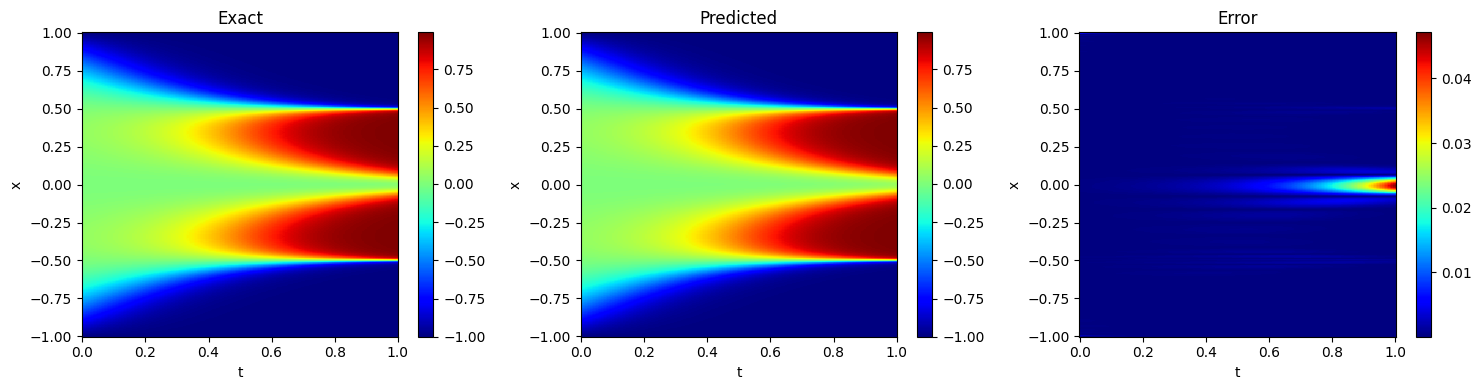

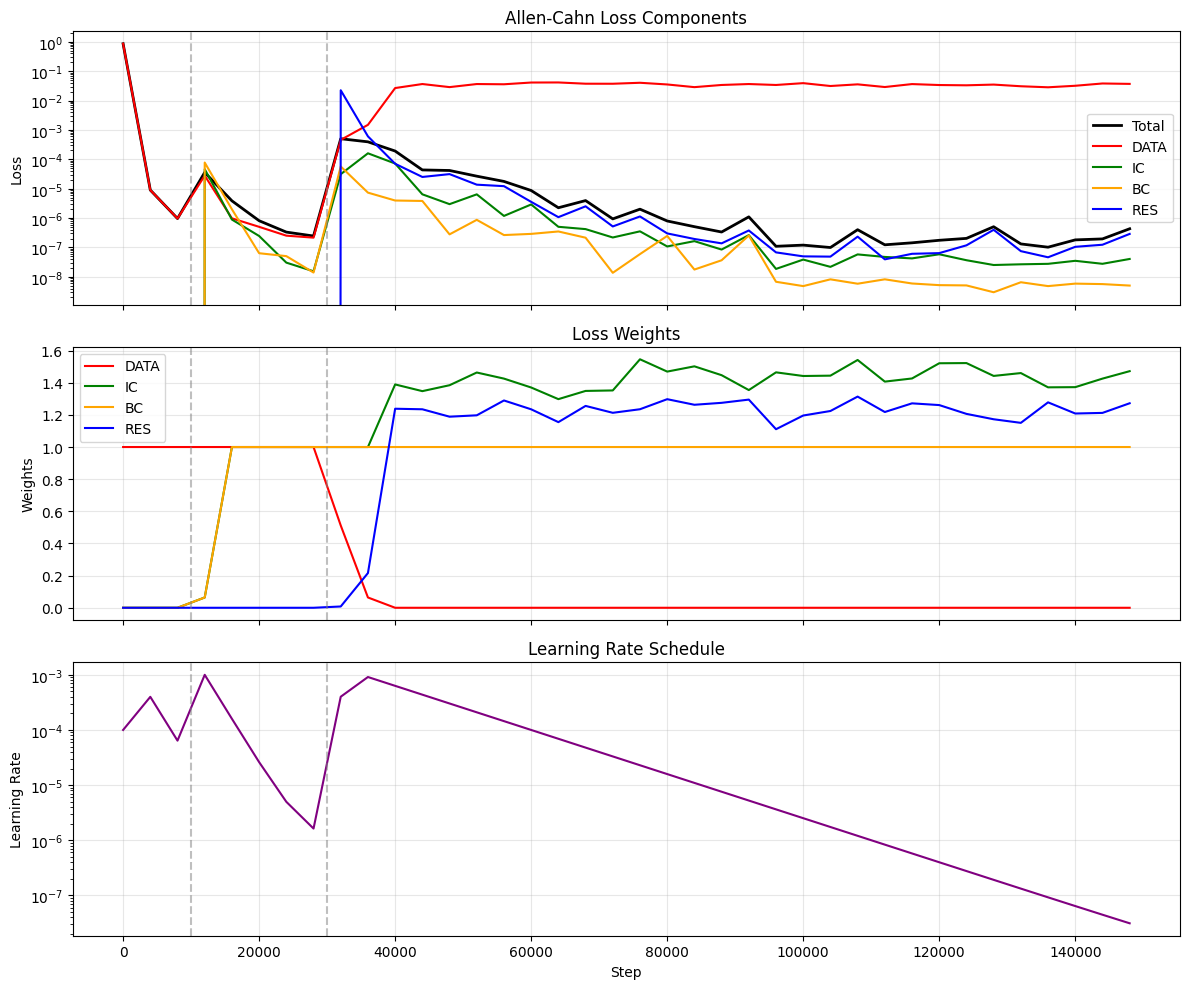

In [7]:
# Allen-Cahn: IC/BC/PDE
def allen_cahn_ic(x):
    return x**2 * jnp.cos(jnp.pi * x)

def allen_cahn_bc(params, u_net, t):
    u_l = u_net(params, t, -1.0)
    u_r = u_net(params, t, 1.0)
    ux_l = grad(u_net, argnums=2)(params, t, -1.0)
    ux_r = grad(u_net, argnums=2)(params, t, 1.0)
    return (u_l - u_r)**2 + (ux_l - ux_r)**2

def allen_cahn_pde(params, u_net, t, x):
    u = u_net(params, t, x)
    u_t = grad(u_net, argnums=1)(params, t, x)
    u_xx = grad(grad(u_net, argnums=2), argnums=2)(params, t, x)
    return u_t - 0.0001 * u_xx + 5.0 * u**3 - 5.0 * u

# Load reference
data_mat = scipy.io.loadmat('allen_cahn.mat')
u_ref = data_mat['usol']
t_star = data_mat['t'].flatten()
x_star = data_mat['x'].flatten()
u0 = u_ref[0, :]

# Load D-FactNET
try:
    mlp_arch = MLP(num_layers=4, hidden_dim=512, output_dim=15, activation=nn.tanh)
    factorizer = MLPFactorizer(mlp_arch, skip_init=True)
    learned_coeff = factorizer.load_model("/home/madheshmd/grad/pinns_research/pinns/Pinns_DfactNET/ac_1d_v1")
    print("D-FactNET loaded for Allen-Cahn")

    approx_dx, approx_dt = 0.01, 1e-4
    approx_x = jnp.arange(-1.0, 1.0, approx_dx)
    approx_t = jnp.arange(0, 1, approx_dt)
    approx_U0 = jnp.interp(approx_x, x_star, u0)

    A, B, C, D, E = [learned_coeff[:, i] for i in range(5)]
    update_coeff = jnp.stack([-A / D, -B / D, -C / D, -E / D], axis=1)

    def time_step(u_j, _, coeffs):
        u_im1, u_ij, u_ip1 = jnp.roll(u_j, 1), u_j, jnp.roll(u_j, -1)
        u_matrix = jnp.stack([u_im1, u_ij, u_ip1, jnp.ones_like(u_j)], axis=0)
        return jnp.median(jnp.clip(coeffs @ u_matrix, -1.0, 1.0), axis=0), None

    def full_solve(u0_vec, coeffs, num_steps):
        def step(carry, _):
            u_new, _ = time_step(carry, None, coeffs)
            return u_new, carry
        _, U = jax.lax.scan(step, u0_vec, None, length=num_steps - 1)
        return jnp.vstack([u0_vec, U])

    U_approx = full_solve(approx_U0, update_coeff, len(approx_t))
    data_coords = (approx_t, approx_x)
    u_data = U_approx
except Exception as e:
    print(f"D-FactNET failed ({e}), using reference")
    data_coords = (t_star, x_star)
    u_data = u_ref

# Config
CONFIG_AC = {
    'pde_type': 'allen_cahn',
    'num_layers': 4, 'embed_dim': 128, 'hidden_dim': 128,
    'use_fourier': True, 'fourier_scale': 2.0, 'alpha_init': 1.0,
    'lr_schedule': {
        'phase1': {'lr_init': 1e-4, 'lr_peak': 1e-3, 'lr_end': 1e-6, 'warmup_steps': 2000, 'decay_steps': 5000, 'decay_rate': 0.1},
        'phase2': {'lr_peak': 1e-3, 'lr_end': 1e-6, 'warmup_steps': 2000, 'decay_steps': 5000, 'decay_rate': 0.1},
        'phase3': {'lr_peak': 1e-3, 'lr_end': 1e-9, 'warmup_steps': 5000, 'decay_steps': 25000, 'decay_rate': 0.1},
    },
    'phase1_steps': 10000, 'phase2_steps': 20000, 'phase3_steps': 120000,
    'icbc_warmup_steps': 5000, 'res_warmup_steps': 10000, 'data_decay_steps': 10000,
    'use_ntk': True, 'ntk_interval': 2000, 'ntk_samples': 64,
    'batch': {'data': 512, 'ics': 128, 'bc': 128, 'residual': 1024},
    'csv_filename': 'loss_history_allen_cahn_v2_4.csv',
}

# Train
trainer_ac = CurriculumPINNTrainer(CONFIG_AC, u0, x_star)
trainer_ac.set_pde_functions(allen_cahn_ic, allen_cahn_bc, allen_cahn_pde)
n_iter = CONFIG_AC['phase1_steps'] + CONFIG_AC['phase2_steps'] + CONFIG_AC['phase3_steps']
trainer_ac.train(data_coords, u_data, n_iter, log_every=4000)

# Evaluate
u_pred = trainer_ac.predict(t_star, x_star)
l2_err = jnp.linalg.norm(u_pred - u_ref) / jnp.linalg.norm(u_ref)
print(f"\nAllen-Cahn L2 Error: {l2_err:.4e}")

# Plot
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
for ax, data, title in zip(axes, [u_ref, u_pred, jnp.abs(u_ref - u_pred)], ['Exact', 'Predicted', 'Error']):
    im = ax.pcolormesh(t_star, x_star, data.T, cmap='jet', shading='auto')
    ax.set_xlabel('t'); ax.set_ylabel('x'); ax.set_title(title); plt.colorbar(im, ax=ax)
plt.tight_layout(); plt.savefig('allen_cahn_results_v2_4.png', dpi=150); plt.show()

# Loss, Weight, and LR plots (stacked)
fig, axes = plt.subplots(3, 1, figsize=(12, 10), sharex=True)
steps = [l['step'] for l in trainer_ac.loss_log]

# Plot losses
axes[0].semilogy(steps, [l['loss'] for l in trainer_ac.loss_log], 'k-', lw=2, label='Total')
axes[0].semilogy(steps, [l['data'] for l in trainer_ac.loss_log], 'r-', label='DATA')
axes[0].semilogy(steps, [l['ic'] for l in trainer_ac.loss_log], 'g-', label='IC')
axes[0].semilogy(steps, [l['bc'] for l in trainer_ac.loss_log], 'orange', label='BC')
axes[0].semilogy(steps, [l['res'] for l in trainer_ac.loss_log], 'b-', label='RES')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)
axes[0].set_title('Allen-Cahn Loss Components')

# Plot weights
axes[1].plot(steps, [l['w_data'] for l in trainer_ac.loss_log], 'r-', label='DATA')
axes[1].plot(steps, [l['w_ic'] for l in trainer_ac.loss_log], 'g-', label='IC')
axes[1].plot(steps, [l['w_bc'] for l in trainer_ac.loss_log], 'orange', label='BC')
axes[1].plot(steps, [l['w_res'] for l in trainer_ac.loss_log], 'b-', label='RES')
axes[1].set_ylabel('Weights')
axes[1].legend()
axes[1].grid(True, alpha=0.3)
axes[1].set_title('Loss Weights')

# Plot learning rate
axes[2].semilogy(steps, [l['lr'] for l in trainer_ac.loss_log], 'purple')
axes[2].set_xlabel('Step')
axes[2].set_ylabel('Learning Rate')
axes[2].grid(True, alpha=0.3)
axes[2].set_title('Learning Rate Schedule')

# Phase boundaries
for ax in axes:
    ax.axvline(x=CONFIG_AC['phase1_steps'], color='gray', linestyle='--', alpha=0.5)
    ax.axvline(x=CONFIG_AC['phase1_steps']+CONFIG_AC['phase2_steps'], color='gray', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.savefig('allen_cahn_loss_history.png', dpi=150)
plt.show()

## Burgers Equation

$$u_t + u u_x = \nu u_{xx}$$

D-FactNET loaded.

CPINNS V2.4 - BURGERS
CSV: loss_history_burgers_v2_4.csv


[P1] lr=1.0e-04 | Loss=4.44e-01:   0%|          | 1/150000 [00:00<35:07:35,  1.19it/s]


[0] Phase 1 | lr=1.0e-04 | grad=4.9e+00
  Losses: DATA=4.44e-01 IC=0.00e+00 BC=0.00e+00 RES=0.00e+00
  Weights: DATA=1.000 IC=0.000 BC=0.000 RES=0.000


[P1] lr=2.7e-05 | Loss=4.59e-06:   7%|▋         | 9976/150000 [00:42<09:21, 249.16it/s]


>>> Phase 2 started at step 10000


[P2] lr=1.0e-06 | Loss=1.83e-05:   7%|▋         | 10001/150000 [00:44<1:19:24, 29.38it/s]


[10000] Phase 2 | lr=1.0e-06 | grad=1.1e-02
  Losses: DATA=1.83e-05 IC=3.42e-06 BC=1.67e-04 RES=0.00e+00
  Weights: DATA=1.000 IC=0.000 BC=0.000 RES=0.000


[P2] lr=2.6e-05 | Loss=1.95e-06:  13%|█▎        | 20020/150000 [02:32<22:14, 97.40it/s]  


[20000] Phase 2 | lr=2.6e-05 | grad=4.0e-03
  Losses: DATA=1.82e-06 IC=8.07e-08 BC=5.13e-08 RES=0.00e+00
  Weights: DATA=1.000 IC=1.000 BC=1.000 RES=0.000


[P2] lr=1.3e-06 | Loss=1.81e-06:  20%|█▉        | 29998/150000 [04:20<23:01, 86.89it/s] 


>>> Phase 3 started at step 30000


[P3] lr=1.0e-06 | Loss=1.24e-06:  20%|█▉        | 29998/150000 [04:28<23:01, 86.89it/s]


[30000] Phase 3 | lr=1.0e-06 | grad=1.2e-03
  Losses: DATA=1.20e-06 IC=1.66e-08 BC=1.88e-08 RES=1.38e+03
  Weights: DATA=1.000 IC=1.000 BC=1.000 RES=0.000


[P3] lr=6.3e-04 | Loss=4.99e-04:  27%|██▋       | 40002/150000 [15:54<4:45:16,  6.43it/s]

>>> NTK: IC=1.036 BC=1.937 RES=1.000

[40000] Phase 3 | lr=6.3e-04 | grad=5.2e-01
  Losses: DATA=2.45e-03 IC=1.11e-04 BC=1.75e-06 RES=3.81e-04
  Weights: DATA=0.000 IC=1.036 BC=1.937 RES=1.000


[P3] lr=5.2e-04 | Loss=2.02e-04:  28%|██▊       | 42004/150000 [18:04<3:40:29,  8.16it/s]

>>> NTK: IC=1.088 BC=1.857 RES=1.000


[P3] lr=4.4e-04 | Loss=6.07e-04:  29%|██▉       | 44002/150000 [20:13<4:21:59,  6.74it/s]

>>> NTK: IC=1.109 BC=1.821 RES=1.000


[P3] lr=3.6e-04 | Loss=4.14e-04:  31%|███       | 46004/150000 [22:24<3:29:57,  8.26it/s]

>>> NTK: IC=1.100 BC=1.798 RES=1.000


[P3] lr=3.0e-04 | Loss=1.25e-03:  32%|███▏      | 48004/150000 [24:33<3:27:26,  8.19it/s]

>>> NTK: IC=1.084 BC=1.747 RES=1.000


[P3] lr=2.5e-04 | Loss=2.31e-05:  33%|███▎      | 50002/150000 [26:42<4:04:27,  6.82it/s]

>>> NTK: IC=1.142 BC=1.804 RES=1.000

[50000] Phase 3 | lr=2.5e-04 | grad=2.0e-01
  Losses: DATA=5.85e-03 IC=6.47e-07 BC=3.29e-07 RES=2.17e-05
  Weights: DATA=0.000 IC=1.142 BC=1.804 RES=1.000


[P3] lr=2.1e-04 | Loss=6.91e-06:  35%|███▍      | 52004/150000 [28:52<3:19:10,  8.20it/s]

>>> NTK: IC=1.090 BC=1.707 RES=1.000


[P3] lr=1.7e-04 | Loss=1.45e-05:  36%|███▌      | 54002/150000 [31:01<3:57:32,  6.74it/s]

>>> NTK: IC=1.112 BC=1.682 RES=1.000


[P3] lr=1.4e-04 | Loss=4.43e-06:  37%|███▋      | 56004/150000 [33:11<3:12:14,  8.15it/s]

>>> NTK: IC=1.092 BC=1.653 RES=1.000


[P3] lr=1.2e-04 | Loss=6.13e-06:  39%|███▊      | 58004/150000 [35:21<3:05:22,  8.27it/s]

>>> NTK: IC=1.086 BC=1.716 RES=1.000


[P3] lr=1.0e-04 | Loss=1.22e-04:  40%|████      | 60004/150000 [37:30<3:02:22,  8.22it/s]

>>> NTK: IC=1.120 BC=1.663 RES=1.000

[60000] Phase 3 | lr=1.0e-04 | grad=4.6e-01
  Losses: DATA=1.81e-03 IC=1.30e-06 BC=3.34e-07 RES=1.20e-04
  Weights: DATA=0.000 IC=1.120 BC=1.663 RES=1.000


[P3] lr=8.3e-05 | Loss=1.56e-06:  41%|████▏     | 62002/150000 [39:39<3:37:09,  6.75it/s]

>>> NTK: IC=1.082 BC=1.658 RES=1.000


[P3] lr=6.9e-05 | Loss=1.33e-06:  43%|████▎     | 64004/150000 [41:48<2:53:25,  8.26it/s]

>>> NTK: IC=1.077 BC=1.644 RES=1.000


[P3] lr=5.8e-05 | Loss=8.53e-06:  44%|████▍     | 66002/150000 [43:58<3:58:29,  5.87it/s]

>>> NTK: IC=1.105 BC=1.727 RES=1.000


[P3] lr=4.8e-05 | Loss=7.09e-05:  45%|████▌     | 68004/150000 [46:08<2:47:41,  8.15it/s]

>>> NTK: IC=1.066 BC=1.568 RES=1.000


[P3] lr=4.0e-05 | Loss=1.51e-04:  47%|████▋     | 70004/150000 [48:16<2:45:41,  8.05it/s]

>>> NTK: IC=1.104 BC=1.678 RES=1.000

[70000] Phase 3 | lr=4.0e-05 | grad=5.9e-01
  Losses: DATA=5.80e-03 IC=6.76e-06 BC=2.54e-06 RES=1.39e-04
  Weights: DATA=0.000 IC=1.104 BC=1.678 RES=1.000


[P3] lr=3.3e-05 | Loss=4.45e-07:  48%|████▊     | 72002/150000 [50:26<3:14:42,  6.68it/s]

>>> NTK: IC=1.096 BC=1.682 RES=1.000


[P3] lr=2.8e-05 | Loss=4.31e-07:  49%|████▉     | 74002/150000 [52:35<3:10:14,  6.66it/s]

>>> NTK: IC=1.087 BC=1.661 RES=1.000


[P3] lr=2.3e-05 | Loss=1.57e-06:  51%|█████     | 76004/150000 [54:44<2:30:48,  8.18it/s]

>>> NTK: IC=1.108 BC=1.610 RES=1.000


[P3] lr=1.9e-05 | Loss=3.73e-07:  52%|█████▏    | 78002/150000 [56:53<2:58:19,  6.73it/s]

>>> NTK: IC=1.081 BC=1.592 RES=1.000


[P3] lr=1.6e-05 | Loss=3.15e-07:  53%|█████▎    | 80004/150000 [59:03<2:23:18,  8.14it/s]

>>> NTK: IC=1.158 BC=1.741 RES=1.000

[80000] Phase 3 | lr=1.6e-05 | grad=1.3e-02
  Losses: DATA=1.67e-03 IC=1.16e-08 BC=2.44e-09 RES=2.97e-07
  Weights: DATA=0.000 IC=1.158 BC=1.741 RES=1.000


[P3] lr=1.3e-05 | Loss=2.26e-06:  55%|█████▍    | 82004/150000 [1:01:13<2:15:33,  8.36it/s]

>>> NTK: IC=1.195 BC=1.780 RES=1.000


[P3] lr=1.1e-05 | Loss=6.14e-07:  56%|█████▌    | 84004/150000 [1:03:22<2:15:32,  8.12it/s]

>>> NTK: IC=1.065 BC=1.600 RES=1.000


[P3] lr=9.1e-06 | Loss=2.69e-07:  57%|█████▋    | 86004/150000 [1:05:32<2:10:55,  8.15it/s]

>>> NTK: IC=1.152 BC=1.709 RES=1.000


[P3] lr=7.6e-06 | Loss=1.26e-07:  59%|█████▊    | 88002/150000 [1:07:41<2:34:43,  6.68it/s]

>>> NTK: IC=1.057 BC=1.601 RES=1.000


[P3] lr=6.3e-06 | Loss=9.77e-08:  60%|██████    | 90004/150000 [1:09:51<2:03:22,  8.10it/s]

>>> NTK: IC=1.110 BC=1.618 RES=1.000

[90000] Phase 3 | lr=6.3e-06 | grad=6.4e-03
  Losses: DATA=1.45e-03 IC=2.76e-09 BC=7.92e-10 RES=9.34e-08
  Weights: DATA=0.000 IC=1.110 BC=1.618 RES=1.000


[P3] lr=5.2e-06 | Loss=1.86e-06:  61%|██████▏   | 92004/150000 [1:12:00<1:58:58,  8.12it/s]

>>> NTK: IC=1.079 BC=1.628 RES=1.000


[P3] lr=4.4e-06 | Loss=1.08e-07:  63%|██████▎   | 94004/150000 [1:14:10<1:55:43,  8.06it/s]

>>> NTK: IC=1.023 BC=1.609 RES=1.000


[P3] lr=3.6e-06 | Loss=1.57e-07:  64%|██████▍   | 96002/150000 [1:16:19<2:13:46,  6.73it/s]

>>> NTK: IC=1.089 BC=1.653 RES=1.000


[P3] lr=3.0e-06 | Loss=1.18e-07:  65%|██████▌   | 98004/150000 [1:18:29<1:46:46,  8.12it/s]

>>> NTK: IC=1.099 BC=1.619 RES=1.000


[P3] lr=2.5e-06 | Loss=6.95e-08:  67%|██████▋   | 100002/150000 [1:20:37<2:01:11,  6.88it/s]

>>> NTK: IC=1.063 BC=1.636 RES=1.000

[100000] Phase 3 | lr=2.5e-06 | grad=2.1e-03
  Losses: DATA=1.15e-02 IC=1.89e-09 BC=5.58e-10 RES=6.66e-08
  Weights: DATA=0.000 IC=1.063 BC=1.636 RES=1.000


[P3] lr=2.1e-06 | Loss=2.84e-07:  68%|██████▊   | 102004/150000 [1:22:48<1:50:38,  7.23it/s]

>>> NTK: IC=1.126 BC=1.677 RES=1.000


[P3] lr=1.7e-06 | Loss=1.20e-07:  69%|██████▉   | 104002/150000 [1:24:58<1:55:39,  6.63it/s]

>>> NTK: IC=1.089 BC=1.642 RES=1.000


[P3] lr=1.4e-06 | Loss=9.44e-08:  71%|███████   | 106004/150000 [1:27:07<1:30:21,  8.12it/s]

>>> NTK: IC=1.124 BC=1.668 RES=1.000


[P3] lr=1.2e-06 | Loss=8.67e-08:  72%|███████▏  | 108004/150000 [1:29:17<1:26:13,  8.12it/s]

>>> NTK: IC=1.090 BC=1.640 RES=1.000


[P3] lr=1.0e-06 | Loss=1.05e-07:  73%|███████▎  | 110002/150000 [1:31:26<1:39:07,  6.73it/s]

>>> NTK: IC=1.035 BC=1.597 RES=1.000

[110000] Phase 3 | lr=1.0e-06 | grad=1.2e-02
  Losses: DATA=7.69e-03 IC=2.42e-09 BC=5.64e-10 RES=1.02e-07
  Weights: DATA=0.000 IC=1.035 BC=1.597 RES=1.000


[P3] lr=8.3e-07 | Loss=7.21e-08:  75%|███████▍  | 112002/150000 [1:33:35<1:33:04,  6.80it/s]

>>> NTK: IC=1.129 BC=1.632 RES=1.000


[P3] lr=6.9e-07 | Loss=4.35e-08:  76%|███████▌  | 114002/150000 [1:35:44<1:29:45,  6.68it/s]

>>> NTK: IC=1.093 BC=1.671 RES=1.000


[P3] lr=5.8e-07 | Loss=1.62e-07:  77%|███████▋  | 116004/150000 [1:37:54<1:08:44,  8.24it/s]

>>> NTK: IC=1.087 BC=1.692 RES=1.000


[P3] lr=4.8e-07 | Loss=4.42e-08:  79%|███████▊  | 118004/150000 [1:40:04<1:05:36,  8.13it/s]

>>> NTK: IC=1.124 BC=1.703 RES=1.000


[P3] lr=4.0e-07 | Loss=6.29e-08:  80%|████████  | 120002/150000 [1:42:14<1:14:14,  6.73it/s]

>>> NTK: IC=1.092 BC=1.627 RES=1.000

[120000] Phase 3 | lr=4.0e-07 | grad=4.2e-03
  Losses: DATA=3.65e-03 IC=1.35e-09 BC=1.41e-10 RES=6.12e-08
  Weights: DATA=0.000 IC=1.092 BC=1.627 RES=1.000


[P3] lr=3.3e-07 | Loss=4.78e-08:  81%|████████▏ | 122004/150000 [1:44:24<57:13,  8.15it/s]  

>>> NTK: IC=1.069 BC=1.632 RES=1.000


[P3] lr=2.8e-07 | Loss=5.73e-08:  83%|████████▎ | 124004/150000 [1:46:33<53:32,  8.09it/s]  

>>> NTK: IC=1.109 BC=1.673 RES=1.000


[P3] lr=2.3e-07 | Loss=5.70e-08:  84%|████████▍ | 126004/150000 [1:48:43<49:43,  8.04it/s]  

>>> NTK: IC=1.069 BC=1.670 RES=1.000


[P3] lr=1.9e-07 | Loss=4.61e-08:  85%|████████▌ | 128002/150000 [1:50:52<53:07,  6.90it/s]

>>> NTK: IC=1.099 BC=1.656 RES=1.000


[P3] lr=1.6e-07 | Loss=5.23e-08:  87%|████████▋ | 130004/150000 [1:53:02<39:57,  8.34it/s]

>>> NTK: IC=1.123 BC=1.677 RES=1.000

[130000] Phase 3 | lr=1.6e-07 | grad=8.5e-04
  Losses: DATA=3.78e-03 IC=1.42e-09 BC=9.57e-11 RES=5.06e-08
  Weights: DATA=0.000 IC=1.123 BC=1.677 RES=1.000


[P3] lr=1.3e-07 | Loss=6.16e-08:  88%|████████▊ | 132002/150000 [1:55:12<44:26,  6.75it/s]

>>> NTK: IC=1.124 BC=1.678 RES=1.000


[P3] lr=1.1e-07 | Loss=5.60e-08:  89%|████████▉ | 134004/150000 [1:57:22<32:33,  8.19it/s]

>>> NTK: IC=1.052 BC=1.579 RES=1.000


[P3] lr=9.2e-08 | Loss=4.95e-08:  91%|█████████ | 136004/150000 [1:59:32<28:50,  8.09it/s]

>>> NTK: IC=1.117 BC=1.664 RES=1.000


[P3] lr=7.7e-08 | Loss=6.03e-08:  92%|█████████▏| 138002/150000 [2:01:42<34:22,  5.82it/s]

>>> NTK: IC=1.061 BC=1.625 RES=1.000


[P3] lr=6.4e-08 | Loss=4.26e-08:  93%|█████████▎| 140002/150000 [2:03:51<24:39,  6.76it/s]

>>> NTK: IC=1.070 BC=1.666 RES=1.000

[140000] Phase 3 | lr=6.4e-08 | grad=2.5e-04
  Losses: DATA=5.83e-03 IC=1.14e-09 BC=6.47e-11 RES=4.12e-08
  Weights: DATA=0.000 IC=1.070 BC=1.666 RES=1.000


[P3] lr=5.3e-08 | Loss=4.81e-08:  95%|█████████▍| 142004/150000 [2:06:01<16:08,  8.26it/s]

>>> NTK: IC=1.129 BC=1.652 RES=1.000


[P3] lr=4.5e-08 | Loss=4.18e-08:  96%|█████████▌| 144002/150000 [2:08:10<15:07,  6.61it/s]

>>> NTK: IC=1.074 BC=1.656 RES=1.000


[P3] lr=3.7e-08 | Loss=4.69e-08:  97%|█████████▋| 146002/150000 [2:10:20<09:58,  6.68it/s]

>>> NTK: IC=1.078 BC=1.626 RES=1.000


[P3] lr=3.1e-08 | Loss=6.12e-08:  99%|█████████▊| 148002/150000 [2:12:29<04:51,  6.86it/s]

>>> NTK: IC=1.101 BC=1.642 RES=1.000


[P3] lr=2.6e-08 | Loss=5.49e-08: 100%|██████████| 150000/150000 [2:14:38<00:00, 18.57it/s]



TRAINING COMPLETE - CSV: loss_history_burgers_v2_4.csv

Burgers L2 Error: 4.8298e-05


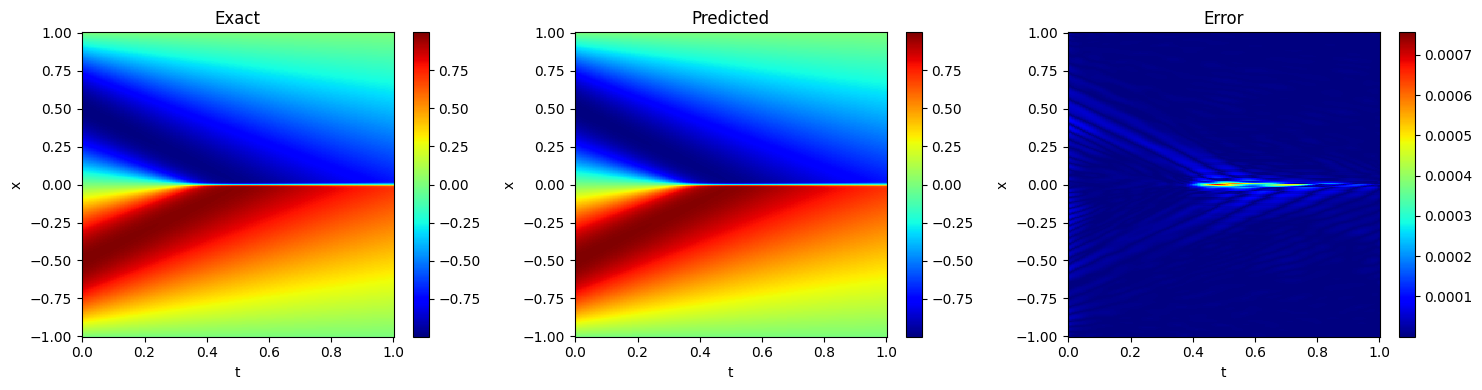

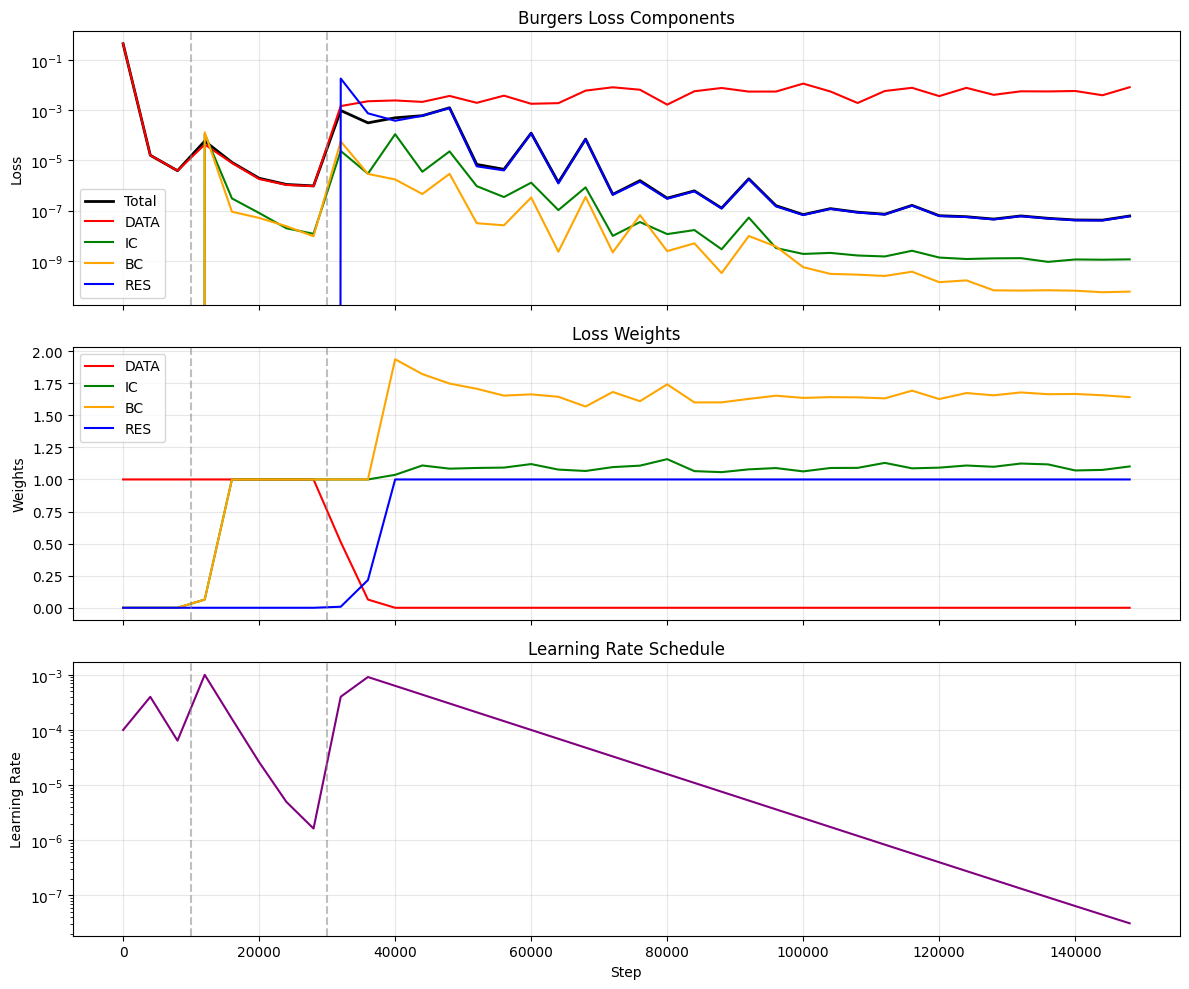

In [9]:
# Burgers: IC/BC/PDE
def burgers_ic(x):
    return -jnp.sin(jnp.pi * x)

def burgers_bc(params, u_net, t):
    u_l = u_net(params, t, -1.0)
    u_r = u_net(params, t, 1.0)
    return u_l**2 + u_r**2

def burgers_pde(params, u_net, t, x, nu=0.01/jnp.pi):
    u = u_net(params, t, x)
    u_t = grad(u_net, argnums=1)(params, t, x)
    u_x = grad(u_net, argnums=2)(params, t, x)
    u_xx = grad(grad(u_net, argnums=2), argnums=2)(params, t, x)
    return u_t + u * u_x - nu * u_xx

# Load reference
data_mat = scipy.io.loadmat('burgers.mat')
u_ref_bg = data_mat['usol']
t_star_bg = data_mat['t'].flatten()
x_star_bg = data_mat['x'].flatten()
u0_bg = u_ref_bg[0, :]

# Load D-FactNET for Burgers
try:
    mlp_arch = MLP(num_layers=4, hidden_dim=512, output_dim=7, activation=nn.tanh)
    factorizer = MLPFactorizer(mlp_arch, skip_init=True)
    learned_coeff = factorizer.load_model('/home/madheshmd/grad/pinns_research/pinns/Pinns_DfactNET/burgers_checkpoint')
    print("D-FactNET loaded.")

    approx_dx, approx_dt = 0.01, 1e-4
    approx_x = jnp.arange(-1.0, 1.0, approx_dx)
    approx_t = jnp.arange(0, 1, approx_dt)
    approx_U0 = jnp.interp(approx_x, x_star_bg, u0_bg)

    # Burgers: 7 coefficients with cross-terms, Dirichlet BC
    A, B, C, D, E, F, G = [learned_coeff[0, i] for i in range(7)]

    def time_step(u, _):
        # Dirichlet BC: only update interior points, boundaries stay 0
        u0_vals = u[:-2]
        u1_vals = u[1:-1]
        u2_vals = u[2:]
        u0_u1 = u0_vals * u1_vals
        u1_u2 = u1_vals * u2_vals
        y_interior = -(A*u0_vals + B*u1_vals + C*u2_vals + D*u0_u1 + E*u1_u2 + G) / F
        y_interior = jnp.clip(y_interior, -1.0, 1.0)
        return jnp.concatenate([jnp.array([0.0]), y_interior, jnp.array([0.0])]), None

    def full_solve(u0_vec, num_steps):
        def step(carry, _):
            u_new, _ = time_step(carry, None)
            return u_new, carry
        _, U = jax.lax.scan(step, u0_vec, None, length=num_steps - 1)
        return jnp.vstack([u0_vec, U])

    U_approx_bg = full_solve(approx_U0, len(approx_t))
    data_coords_bg = (approx_t, approx_x)
    u_data_bg = U_approx_bg

except Exception as e:
    print(f"D-FactNET failed ({e}), using reference data")
    data_coords_bg = (t_star_bg, x_star_bg)
    u_data_bg = u_ref_bg

# Config
CONFIG_BG = {
    'pde_type': 'burgers',
    'num_layers': 4, 'embed_dim': 128, 'hidden_dim': 128,
    'use_fourier': True, 'fourier_scale': 2.0, 'alpha_init': 1.0,
    'lr_schedule': {
        'phase1': {'lr_init': 1e-4, 'lr_peak': 1e-3, 'lr_end': 1e-6, 'warmup_steps': 2000, 'decay_steps': 5000, 'decay_rate': 0.1},
        'phase2': {'lr_peak': 1e-3, 'lr_end': 1e-6, 'warmup_steps': 2000, 'decay_steps': 5000, 'decay_rate': 0.1},
        'phase3': {'lr_peak': 1e-3, 'lr_end': 1e-9, 'warmup_steps': 5000, 'decay_steps': 25000, 'decay_rate': 0.1},
    },
    'phase1_steps': 10000, 'phase2_steps': 20000, 'phase3_steps': 120000,
    'icbc_warmup_steps': 5000, 'res_warmup_steps': 10000, 'data_decay_steps': 10000,
    'use_ntk': True, 'ntk_interval': 2000, 'ntk_samples': 64,
    'batch': {'data': 512, 'ics': 128, 'bc': 128, 'residual': 1024},
    'csv_filename': 'loss_history_burgers_v2_4.csv',
}

# Train
trainer_bg = CurriculumPINNTrainer(CONFIG_BG, u0_bg, x_star_bg)
trainer_bg.set_pde_functions(burgers_ic, burgers_bc, burgers_pde)
n_iter_bg = CONFIG_BG['phase1_steps'] + CONFIG_BG['phase2_steps'] + CONFIG_BG['phase3_steps']
trainer_bg.train(data_coords_bg, u_data_bg, n_iter_bg, log_every=4000)

# Evaluate
u_pred_bg = trainer_bg.predict(t_star_bg, x_star_bg)
l2_err_bg = jnp.linalg.norm(u_pred_bg - u_ref_bg) / jnp.linalg.norm(u_ref_bg)
print(f"\nBurgers L2 Error: {l2_err_bg:.4e}")

# Plot
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
for ax, data, title in zip(axes, [u_ref_bg, u_pred_bg, jnp.abs(u_ref_bg - u_pred_bg)], ['Exact', 'Predicted', 'Error']):
    im = ax.pcolormesh(t_star_bg, x_star_bg, data.T, cmap='jet', shading='auto')
    ax.set_xlabel('t'); ax.set_ylabel('x'); ax.set_title(title); plt.colorbar(im, ax=ax)
plt.tight_layout(); plt.savefig('burgers_results_v2_4.png', dpi=150); plt.show()

# Loss, Weight, and LR plots (stacked)
fig, axes = plt.subplots(3, 1, figsize=(12, 10), sharex=True)
steps = [l['step'] for l in trainer_bg.loss_log]

# Plot losses
axes[0].semilogy(steps, [l['loss'] for l in trainer_bg.loss_log], 'k-', lw=2, label='Total')
axes[0].semilogy(steps, [l['data'] for l in trainer_bg.loss_log], 'r-', label='DATA')
axes[0].semilogy(steps, [l['ic'] for l in trainer_bg.loss_log], 'g-', label='IC')
axes[0].semilogy(steps, [l['bc'] for l in trainer_bg.loss_log], 'orange', label='BC')
axes[0].semilogy(steps, [l['res'] for l in trainer_bg.loss_log], 'b-', label='RES')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)
axes[0].set_title('Burgers Loss Components')

# Plot weights
axes[1].plot(steps, [l['w_data'] for l in trainer_bg.loss_log], 'r-', label='DATA')
axes[1].plot(steps, [l['w_ic'] for l in trainer_bg.loss_log], 'g-', label='IC')
axes[1].plot(steps, [l['w_bc'] for l in trainer_bg.loss_log], 'orange', label='BC')
axes[1].plot(steps, [l['w_res'] for l in trainer_bg.loss_log], 'b-', label='RES')
axes[1].set_ylabel('Weights')
axes[1].legend()
axes[1].grid(True, alpha=0.3)
axes[1].set_title('Loss Weights')

# Plot learning rate
axes[2].semilogy(steps, [l['lr'] for l in trainer_bg.loss_log], 'purple')
axes[2].set_xlabel('Step')
axes[2].set_ylabel('Learning Rate')
axes[2].grid(True, alpha=0.3)
axes[2].set_title('Learning Rate Schedule')

# Phase boundaries
for ax in axes:
    ax.axvline(x=CONFIG_BG['phase1_steps'], color='gray', linestyle='--', alpha=0.5)
    ax.axvline(x=CONFIG_BG['phase1_steps']+CONFIG_BG['phase2_steps'], color='gray', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.savefig('burgers_loss_history.png', dpi=150)
plt.show()

## KdV Equation

$$u_t + \eta u u_x + \mu^2 u_{xxx} = 0$$

D-FactNET loaded for KdV

CPINNS V2.4 - KDV
CSV: loss_history_kdv_v2_4.csv


[P1] lr=1.0e-04 | Loss=8.27e-01:   0%|          | 1/150000 [00:01<62:32:24,  1.50s/it]


[0] Phase 1 | lr=1.0e-04 | grad=5.7e+00
  Losses: DATA=8.27e-01 IC=0.00e+00 BC=0.00e+00 RES=0.00e+00
  Weights: DATA=1.000 IC=0.000 BC=0.000 RES=0.000


[P1] lr=2.7e-05 | Loss=8.77e-07:   7%|▋         | 9975/150000 [00:26<05:48, 401.62it/s]


>>> Phase 2 started at step 10000


[P2] lr=1.0e-06 | Loss=1.46e-06:   7%|▋         | 10016/150000 [00:31<1:22:59, 28.11it/s]


[10000] Phase 2 | lr=1.0e-06 | grad=5.9e-03
  Losses: DATA=1.46e-06 IC=1.86e-05 BC=1.07e+00 RES=0.00e+00
  Weights: DATA=1.000 IC=0.000 BC=0.000 RES=0.000


[P2] lr=2.6e-05 | Loss=1.46e-06:  13%|█▎        | 20012/150000 [02:46<28:44, 75.39it/s]  


[20000] Phase 2 | lr=2.6e-05 | grad=6.6e-03
  Losses: DATA=1.01e-06 IC=1.25e-07 BC=3.29e-07 RES=0.00e+00
  Weights: DATA=1.000 IC=1.000 BC=1.000 RES=0.000


[P2] lr=1.3e-06 | Loss=8.42e-07:  20%|█▉        | 29996/150000 [05:01<27:49, 71.87it/s]


>>> Phase 3 started at step 30000


[P3] lr=1.0e-06 | Loss=9.41e-07:  20%|██        | 30003/150000 [05:18<21:10:35,  1.57it/s]


[30000] Phase 3 | lr=1.0e-06 | grad=1.7e-03
  Losses: DATA=8.99e-07 IC=3.29e-08 BC=8.81e-09 RES=3.96e+05
  Weights: DATA=1.000 IC=1.000 BC=1.000 RES=0.000


[P3] lr=5.6e-04 | Loss=2.59e-02:  27%|██▋       | 40002/150000 [21:15<5:25:01,  5.64it/s] 

>>> NTK: IC=1.552 BC=1.000 RES=1.067

[40000] Phase 3 | lr=5.6e-04 | grad=5.3e+00
  Losses: DATA=2.33e-01 IC=6.58e-03 BC=1.13e-03 RES=1.36e-02
  Weights: DATA=0.000 IC=1.552 BC=1.000 RES=1.067


[P3] lr=4.5e-04 | Loss=2.31e-02:  28%|██▊       | 42002/150000 [24:18<5:13:32,  5.74it/s]

>>> NTK: IC=1.509 BC=1.000 RES=1.045


[P3] lr=3.5e-04 | Loss=6.99e-03:  29%|██▉       | 44002/150000 [27:22<5:13:47,  5.63it/s]

>>> NTK: IC=1.463 BC=1.044 RES=1.000


[P3] lr=2.8e-04 | Loss=1.14e-02:  31%|███       | 46002/150000 [30:26<5:01:11,  5.75it/s]

>>> NTK: IC=1.550 BC=1.053 RES=1.000


[P3] lr=2.2e-04 | Loss=2.89e-03:  32%|███▏      | 48002/150000 [33:30<5:01:19,  5.64it/s]

>>> NTK: IC=1.658 BC=1.166 RES=1.000


[P3] lr=1.8e-04 | Loss=1.23e-03:  33%|███▎      | 50002/150000 [36:34<4:52:44,  5.69it/s]

>>> NTK: IC=1.565 BC=1.110 RES=1.000

[50000] Phase 3 | lr=1.8e-04 | grad=2.4e+00
  Losses: DATA=4.69e-01 IC=1.61e-04 BC=5.35e-05 RES=9.22e-04
  Weights: DATA=0.000 IC=1.565 BC=1.110 RES=1.000


[P3] lr=1.4e-04 | Loss=1.56e-03:  35%|███▍      | 52002/150000 [39:37<4:46:07,  5.71it/s]

>>> NTK: IC=1.656 BC=1.159 RES=1.000


[P3] lr=1.1e-04 | Loss=9.90e-04:  36%|███▌      | 54002/150000 [42:41<5:21:03,  4.98it/s]

>>> NTK: IC=1.417 BC=1.019 RES=1.000


[P3] lr=8.9e-05 | Loss=3.54e-04:  37%|███▋      | 56002/150000 [45:45<4:32:05,  5.76it/s]

>>> NTK: IC=1.659 BC=1.192 RES=1.000


[P3] lr=7.1e-05 | Loss=2.67e-04:  39%|███▊      | 58002/150000 [48:50<4:31:12,  5.65it/s]

>>> NTK: IC=1.690 BC=1.130 RES=1.000


[P3] lr=5.6e-05 | Loss=2.15e-04:  40%|████      | 60002/150000 [51:54<4:28:32,  5.59it/s]

>>> NTK: IC=1.575 BC=1.126 RES=1.000

[60000] Phase 3 | lr=5.6e-05 | grad=5.7e-01
  Losses: DATA=5.43e-01 IC=1.94e-05 BC=4.08e-06 RES=1.80e-04
  Weights: DATA=0.000 IC=1.575 BC=1.126 RES=1.000


[P3] lr=4.5e-05 | Loss=2.78e-04:  41%|████▏     | 62002/150000 [54:59<4:15:34,  5.74it/s]

>>> NTK: IC=1.536 BC=1.077 RES=1.000


[P3] lr=3.5e-05 | Loss=3.02e-04:  43%|████▎     | 64002/150000 [58:02<4:14:51,  5.62it/s]

>>> NTK: IC=1.524 BC=1.090 RES=1.000


[P3] lr=2.8e-05 | Loss=1.59e-04:  44%|████▍     | 66002/150000 [1:01:06<4:09:46,  5.60it/s]

>>> NTK: IC=1.740 BC=1.185 RES=1.000


[P3] lr=2.2e-05 | Loss=1.47e-04:  45%|████▌     | 68002/150000 [1:04:10<3:54:55,  5.82it/s]

>>> NTK: IC=1.723 BC=1.198 RES=1.000


[P3] lr=1.8e-05 | Loss=6.61e-05:  47%|████▋     | 70002/150000 [1:07:14<3:53:33,  5.71it/s]

>>> NTK: IC=1.744 BC=1.195 RES=1.000

[70000] Phase 3 | lr=1.8e-05 | grad=2.7e-01
  Losses: DATA=6.85e-01 IC=7.68e-06 BC=3.26e-06 RES=4.88e-05
  Weights: DATA=0.000 IC=1.744 BC=1.195 RES=1.000


[P3] lr=1.4e-05 | Loss=7.08e-05:  48%|████▊     | 72002/150000 [1:10:18<3:42:36,  5.84it/s]

>>> NTK: IC=1.662 BC=1.159 RES=1.000


[P3] lr=1.1e-05 | Loss=6.34e-05:  49%|████▉     | 74002/150000 [1:13:21<3:41:21,  5.72it/s]

>>> NTK: IC=1.682 BC=1.128 RES=1.000


[P3] lr=8.9e-06 | Loss=4.36e-05:  51%|█████     | 76002/150000 [1:16:25<3:32:35,  5.80it/s]

>>> NTK: IC=1.532 BC=1.103 RES=1.000


[P3] lr=7.1e-06 | Loss=5.07e-05:  52%|█████▏    | 78002/150000 [1:19:29<3:25:44,  5.83it/s]

>>> NTK: IC=1.742 BC=1.205 RES=1.000


[P3] lr=5.6e-06 | Loss=4.10e-05:  53%|█████▎    | 80002/150000 [1:22:32<3:22:00,  5.78it/s]

>>> NTK: IC=1.584 BC=1.154 RES=1.000

[80000] Phase 3 | lr=5.6e-06 | grad=1.8e-01
  Losses: DATA=7.32e-01 IC=5.03e-06 BC=1.78e-06 RES=3.10e-05
  Weights: DATA=0.000 IC=1.584 BC=1.154 RES=1.000


[P3] lr=4.5e-06 | Loss=3.22e-05:  55%|█████▍    | 82002/150000 [1:25:36<3:17:49,  5.73it/s]

>>> NTK: IC=1.568 BC=1.098 RES=1.000


[P3] lr=3.5e-06 | Loss=3.40e-05:  56%|█████▌    | 84002/150000 [1:28:40<3:12:29,  5.71it/s]

>>> NTK: IC=1.558 BC=1.113 RES=1.000


[P3] lr=2.8e-06 | Loss=5.43e-05:  57%|█████▋    | 86002/150000 [1:31:44<3:04:51,  5.77it/s]

>>> NTK: IC=1.732 BC=1.194 RES=1.000


[P3] lr=2.2e-06 | Loss=3.28e-05:  59%|█████▊    | 88002/150000 [1:34:48<2:59:58,  5.74it/s]

>>> NTK: IC=1.569 BC=1.056 RES=1.000


[P3] lr=1.8e-06 | Loss=2.72e-05:  60%|██████    | 90002/150000 [1:37:52<2:52:34,  5.79it/s]

>>> NTK: IC=1.581 BC=1.080 RES=1.000

[90000] Phase 3 | lr=1.8e-06 | grad=8.0e-02
  Losses: DATA=4.97e-01 IC=4.41e-06 BC=7.89e-07 RES=1.94e-05
  Weights: DATA=0.000 IC=1.581 BC=1.080 RES=1.000


[P3] lr=1.4e-06 | Loss=2.85e-05:  61%|██████▏   | 92002/150000 [1:40:56<2:43:50,  5.90it/s]

>>> NTK: IC=1.599 BC=1.115 RES=1.000


[P3] lr=1.1e-06 | Loss=2.73e-05:  63%|██████▎   | 94002/150000 [1:43:59<3:03:50,  5.08it/s]

>>> NTK: IC=1.603 BC=1.144 RES=1.000


[P3] lr=8.9e-07 | Loss=2.73e-05:  64%|██████▍   | 96002/150000 [1:47:03<2:37:14,  5.72it/s]

>>> NTK: IC=1.843 BC=1.249 RES=1.000


[P3] lr=7.1e-07 | Loss=3.05e-05:  65%|██████▌   | 98002/150000 [1:50:07<2:31:25,  5.72it/s]

>>> NTK: IC=1.726 BC=1.164 RES=1.000


[P3] lr=5.6e-07 | Loss=2.49e-05:  67%|██████▋   | 100002/150000 [1:53:10<2:25:09,  5.74it/s]

>>> NTK: IC=1.483 BC=1.094 RES=1.000

[100000] Phase 3 | lr=5.6e-07 | grad=3.7e-02
  Losses: DATA=4.58e-01 IC=3.40e-06 BC=1.06e-06 RES=1.87e-05
  Weights: DATA=0.000 IC=1.483 BC=1.094 RES=1.000


[P3] lr=4.5e-07 | Loss=2.71e-05:  68%|██████▊   | 102002/150000 [1:56:14<2:20:12,  5.71it/s]

>>> NTK: IC=1.768 BC=1.185 RES=1.000


[P3] lr=3.6e-07 | Loss=2.28e-05:  69%|██████▉   | 104002/150000 [1:59:18<2:14:19,  5.71it/s]

>>> NTK: IC=1.622 BC=1.155 RES=1.000


[P3] lr=2.8e-07 | Loss=2.27e-05:  71%|███████   | 106002/150000 [2:02:22<2:06:44,  5.79it/s]

>>> NTK: IC=1.540 BC=1.139 RES=1.000


[P3] lr=2.2e-07 | Loss=2.54e-05:  72%|███████▏  | 108002/150000 [2:05:27<1:59:33,  5.85it/s]

>>> NTK: IC=1.687 BC=1.170 RES=1.000


[P3] lr=1.8e-07 | Loss=2.46e-05:  73%|███████▎  | 110002/150000 [2:08:30<1:55:39,  5.76it/s]

>>> NTK: IC=1.724 BC=1.146 RES=1.000

[110000] Phase 3 | lr=1.8e-07 | grad=7.7e-02
  Losses: DATA=4.32e-01 IC=4.29e-06 BC=7.56e-07 RES=1.64e-05
  Weights: DATA=0.000 IC=1.724 BC=1.146 RES=1.000


[P3] lr=1.4e-07 | Loss=2.53e-05:  75%|███████▍  | 112002/150000 [2:11:34<1:50:22,  5.74it/s]

>>> NTK: IC=1.722 BC=1.213 RES=1.000


[P3] lr=1.1e-07 | Loss=2.41e-05:  76%|███████▌  | 114002/150000 [2:14:38<1:44:26,  5.74it/s]

>>> NTK: IC=1.776 BC=1.192 RES=1.000


[P3] lr=9.0e-08 | Loss=2.15e-05:  77%|███████▋  | 116002/150000 [2:17:42<1:38:29,  5.75it/s]

>>> NTK: IC=1.694 BC=1.188 RES=1.000


[P3] lr=7.2e-08 | Loss=2.46e-05:  79%|███████▊  | 118002/150000 [2:20:46<1:33:59,  5.67it/s]

>>> NTK: IC=1.534 BC=1.071 RES=1.000


[P3] lr=5.7e-08 | Loss=1.97e-05:  80%|████████  | 120002/150000 [2:23:49<1:26:23,  5.79it/s]

>>> NTK: IC=1.626 BC=1.094 RES=1.000

[120000] Phase 3 | lr=5.7e-08 | grad=3.6e-02
  Losses: DATA=5.62e-01 IC=2.64e-06 BC=4.92e-07 RES=1.49e-05
  Weights: DATA=0.000 IC=1.626 BC=1.094 RES=1.000


[P3] lr=4.6e-08 | Loss=2.02e-05:  81%|████████▏ | 122002/150000 [2:26:53<1:19:44,  5.85it/s]

>>> NTK: IC=1.527 BC=1.069 RES=1.000


[P3] lr=3.6e-08 | Loss=2.12e-05:  83%|████████▎ | 124002/150000 [2:29:57<1:16:03,  5.70it/s]

>>> NTK: IC=1.557 BC=1.073 RES=1.000


[P3] lr=2.9e-08 | Loss=2.48e-05:  84%|████████▍ | 126002/150000 [2:33:01<1:08:19,  5.85it/s]

>>> NTK: IC=1.554 BC=1.104 RES=1.000


[P3] lr=2.3e-08 | Loss=1.95e-05:  85%|████████▌ | 128002/150000 [2:36:05<1:02:30,  5.87it/s]

>>> NTK: IC=1.559 BC=1.112 RES=1.000


[P3] lr=1.9e-08 | Loss=2.44e-05:  87%|████████▋ | 130002/150000 [2:39:08<57:51,  5.76it/s]  

>>> NTK: IC=1.554 BC=1.078 RES=1.000

[130000] Phase 3 | lr=1.9e-08 | grad=3.8e-02
  Losses: DATA=4.93e-01 IC=5.32e-06 BC=7.04e-07 RES=1.54e-05
  Weights: DATA=0.000 IC=1.554 BC=1.078 RES=1.000


[P3] lr=1.5e-08 | Loss=2.58e-05:  88%|████████▊ | 132002/150000 [2:42:12<52:40,  5.70it/s]

>>> NTK: IC=1.661 BC=1.152 RES=1.000


[P3] lr=1.2e-08 | Loss=2.45e-05:  89%|████████▉ | 134002/150000 [2:45:15<53:14,  5.01it/s]

>>> NTK: IC=1.689 BC=1.187 RES=1.000


[P3] lr=9.9e-09 | Loss=2.16e-05:  91%|█████████ | 136002/150000 [2:48:19<40:46,  5.72it/s]

>>> NTK: IC=1.659 BC=1.112 RES=1.000


[P3] lr=8.1e-09 | Loss=2.14e-05:  92%|█████████▏| 138002/150000 [2:51:22<34:18,  5.83it/s]

>>> NTK: IC=1.413 BC=1.000 RES=1.000


[P3] lr=6.6e-09 | Loss=2.32e-05:  93%|█████████▎| 140002/150000 [2:54:26<28:28,  5.85it/s]

>>> NTK: IC=1.697 BC=1.167 RES=1.000

[140000] Phase 3 | lr=6.6e-09 | grad=3.8e-02
  Losses: DATA=4.63e-01 IC=2.65e-06 BC=6.26e-07 RES=1.80e-05
  Weights: DATA=0.000 IC=1.697 BC=1.167 RES=1.000


[P3] lr=5.5e-09 | Loss=2.00e-05:  95%|█████████▍| 142002/150000 [2:57:30<22:45,  5.86it/s]

>>> NTK: IC=1.720 BC=1.157 RES=1.000


[P3] lr=4.5e-09 | Loss=2.21e-05:  96%|█████████▌| 144002/150000 [3:00:34<17:39,  5.66it/s]

>>> NTK: IC=1.592 BC=1.172 RES=1.000


[P3] lr=3.8e-09 | Loss=2.27e-05:  97%|█████████▋| 146002/150000 [3:03:38<11:44,  5.67it/s]

>>> NTK: IC=1.544 BC=1.064 RES=1.000


[P3] lr=3.2e-09 | Loss=2.24e-05:  99%|█████████▊| 148002/150000 [3:06:42<05:50,  5.70it/s]

>>> NTK: IC=1.533 BC=1.082 RES=1.000


[P3] lr=2.8e-09 | Loss=2.21e-05: 100%|██████████| 150000/150000 [3:09:45<00:00, 13.17it/s]



TRAINING COMPLETE - CSV: loss_history_kdv_v2_4.csv

KdV L2 Error: 2.8753e-02


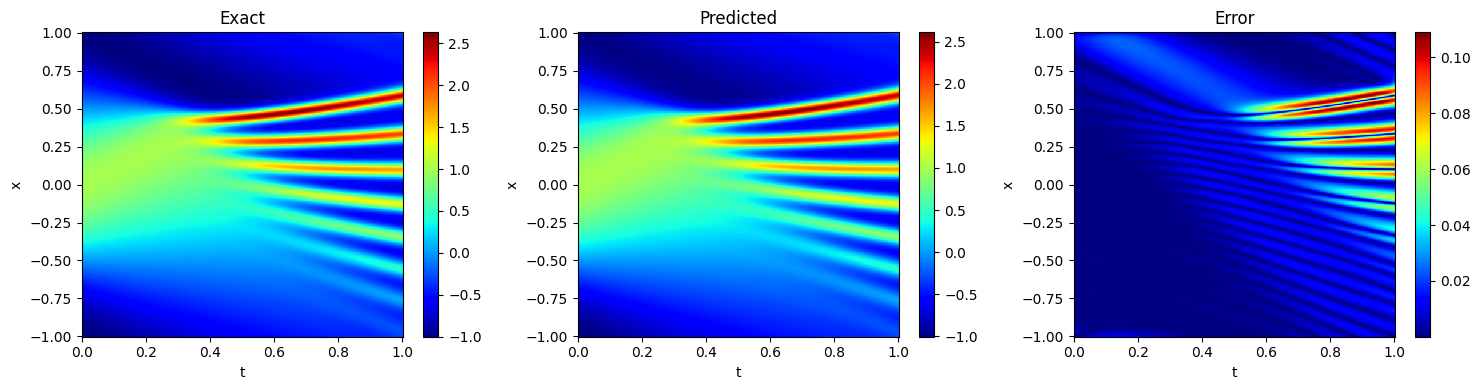

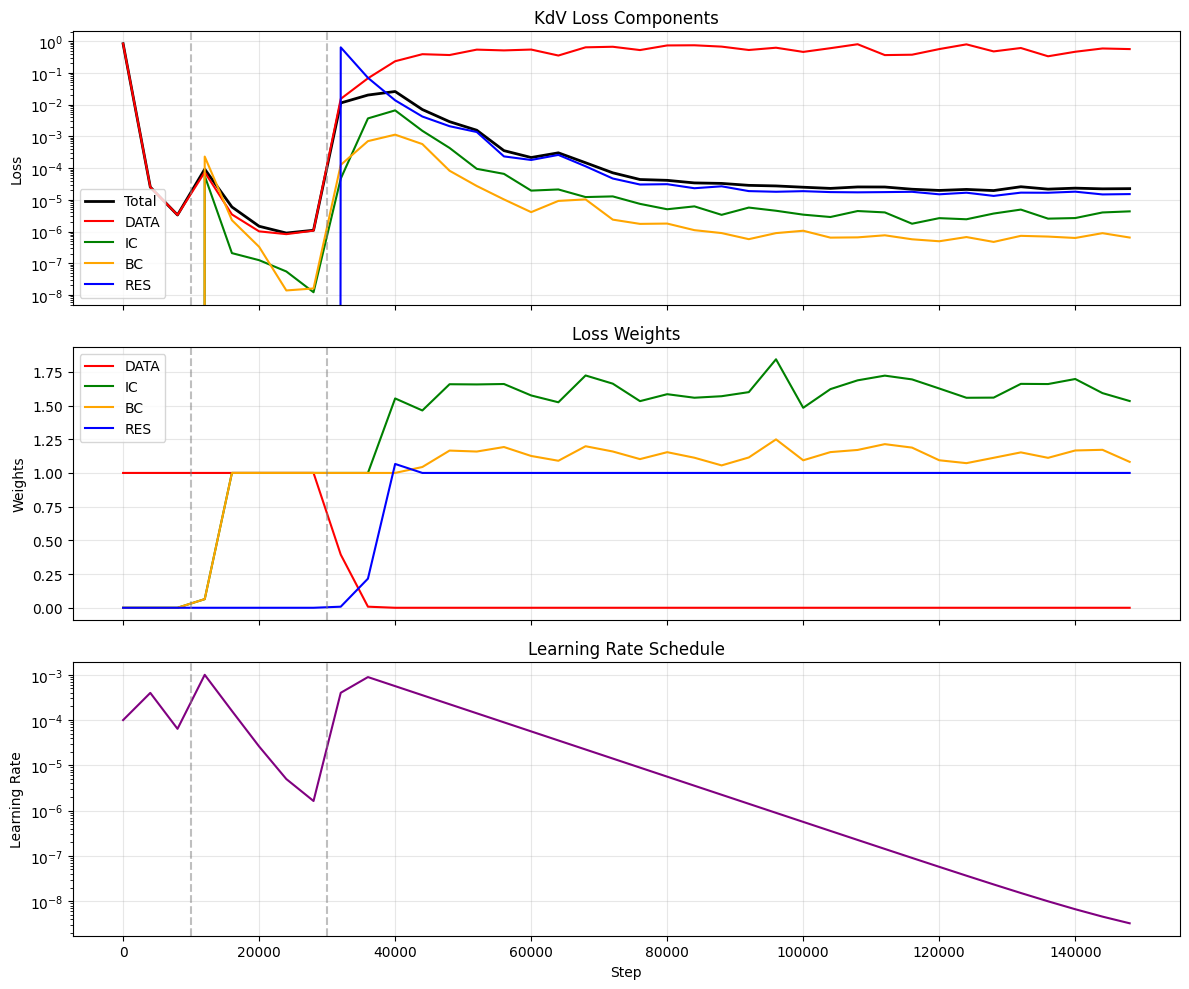

In [10]:
# KdV: IC/BC/PDE
def kdv_ic(x):
    return jnp.cos(jnp.pi * x)

def kdv_bc(params, u_net, t):
    u_l = u_net(params, t, -1.0)
    u_r = u_net(params, t, 1.0)
    ux_l = grad(u_net, argnums=2)(params, t, -1.0)
    ux_r = grad(u_net, argnums=2)(params, t, 1.0)
    return (u_l - u_r)**2 + (ux_l - ux_r)**2

def kdv_pde(params, u_net, t, x, eta=1.0, mu=0.022):
    u = u_net(params, t, x)
    u_t = grad(u_net, argnums=1)(params, t, x)
    u_x = grad(u_net, argnums=2)(params, t, x)
    u_xxx = grad(grad(grad(u_net, argnums=2), argnums=2), argnums=2)(params, t, x)
    return u_t + eta * u * u_x + mu**2 * u_xxx

# Load reference
data_mat = scipy.io.loadmat('kdv.mat')
u_ref_kdv = data_mat['usol']
t_star_kdv = data_mat['t'].flatten()
x_star_kdv = data_mat['x'].flatten()
u0_kdv = u_ref_kdv[0, :]

# Load D-FactNET for KdV
try:
    mlp_arch = MLP(num_layers=4, hidden_dim=256, output_dim=9, activation=nn.tanh)
    factorizer_kdv = MLPFactorizer(mlp_arch, skip_init=True)
    learned_coeff_kdv = factorizer_kdv.load_model('/home/madheshmd/grad/pinns_research/pinns/Pinns_DfactNET/kdv_checkpoint')
    print("D-FactNET loaded for KdV")

    approx_dx, approx_dt = 0.1, 1e-2
    approx_x_kdv = jnp.arange(-1.0, 1.0, approx_dx)
    approx_t_kdv = jnp.arange(0, 1, approx_dt)
    approx_U0_kdv = jnp.interp(approx_x_kdv, x_star_kdv, u0_kdv)

    # KdV: 8 coefficients, 5-point stencil for u_xxx, periodic BC
    A, B, C, D, E, F, G, H, I = [learned_coeff_kdv[0, i] for i in range(9)]

    def time_step_kdv(u, _):
        u0 = jnp.roll(u, 2)   # u_{i-2}
        u1 = jnp.roll(u, 1)   # u_{i-1}
        u2 = u                 # u_i
        u3 = jnp.roll(u, -1)  # u_{i+1}
        u4 = jnp.roll(u, -2)  # u_{i+2}
        u2_u3 = u2 * u3 
        u2_u1 = u2 * u1
        y = -(A*u0 + B*u1 + C*u2 + D*u3 + E*u4 + F*u2_u1 + G*u2_u3 + I) / H
        y = jnp.clip(y, -1.0, 2.5)
        return y, y

    def full_solve_kdv(u0_vec, num_steps):
        def step(carry, _):
            u_new, _ = time_step_kdv(carry, None)
            return u_new, carry
        _, U = jax.lax.scan(step, u0_vec, None, length=num_steps - 1)
        return jnp.vstack([u0_vec, U])

    U_approx_kdv = full_solve_kdv(approx_U0_kdv, len(approx_t_kdv))
    data_coords_kdv = (approx_t_kdv, approx_x_kdv)
    u_data_kdv = U_approx_kdv
except Exception as e:
    print(f"D-FactNET failed ({e}), using reference")
    data_coords_kdv = (t_star_kdv, x_star_kdv)
    u_data_kdv = u_ref_kdv

# Config
CONFIG_KDV = {
    'pde_type': 'kdv',
    'num_layers': 4, 'embed_dim': 128, 'hidden_dim': 128,
    'use_fourier': True, 'fourier_scale': 2.0, 'alpha_init': 1.0,
    'lr_schedule': {
        'phase1': {'lr_init': 1e-4, 'lr_peak': 1e-3, 'lr_end': 1e-6, 'warmup_steps': 2000, 'decay_steps': 5000, 'decay_rate': 0.1},
        'phase2': {'lr_peak': 1e-3, 'lr_end': 1e-6, 'warmup_steps': 2000, 'decay_steps': 5000, 'decay_rate': 0.1},
        'phase3': {'lr_peak': 1e-3, 'lr_end': 1e-9, 'warmup_steps': 5000, 'decay_steps': 20000, 'decay_rate': 0.1},      # lower lr works better
    },
    'phase1_steps': 10000, 'phase2_steps': 20000, 'phase3_steps': 120000,
    'icbc_warmup_steps': 5000, 'res_warmup_steps': 10000, 'data_decay_steps': 7500,
    'use_ntk': True, 'ntk_interval': 2000, 'ntk_samples': 64,
    'batch': {'data': 256, 'ics': 128, 'bc': 128, 'residual': 1024},
    'csv_filename': 'loss_history_kdv_v2_4.csv',
}

# Train
trainer_kdv = CurriculumPINNTrainer(CONFIG_KDV, u0_kdv, x_star_kdv)
trainer_kdv.set_pde_functions(kdv_ic, kdv_bc, kdv_pde)
n_iter_kdv = CONFIG_KDV['phase1_steps'] + CONFIG_KDV['phase2_steps'] + CONFIG_KDV['phase3_steps']
trainer_kdv.train(data_coords_kdv, u_data_kdv, n_iter_kdv, log_every=4000)

# Evaluate
u_pred_kdv = trainer_kdv.predict(t_star_kdv, x_star_kdv)
l2_err_kdv = jnp.linalg.norm(u_pred_kdv - u_ref_kdv) / jnp.linalg.norm(u_ref_kdv)
print(f"\nKdV L2 Error: {l2_err_kdv:.4e}")

# Plot
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
for ax, data, title in zip(axes, [u_ref_kdv, u_pred_kdv, jnp.abs(u_ref_kdv - u_pred_kdv)], ['Exact', 'Predicted', 'Error']):
    im = ax.pcolormesh(t_star_kdv, x_star_kdv, data.T, cmap='jet', shading='auto')
    ax.set_xlabel('t'); ax.set_ylabel('x'); ax.set_title(title); plt.colorbar(im, ax=ax)
plt.tight_layout(); plt.savefig('kdv_results_v2_4.png', dpi=150); plt.show()

# Loss, Weight, and LR plots (stacked)
fig, axes = plt.subplots(3, 1, figsize=(12, 10), sharex=True)
steps = [l['step'] for l in trainer_kdv.loss_log]

# Plot losses
axes[0].semilogy(steps, [l['loss'] for l in trainer_kdv.loss_log], 'k-', lw=2, label='Total')
axes[0].semilogy(steps, [l['data'] for l in trainer_kdv.loss_log], 'r-', label='DATA')
axes[0].semilogy(steps, [l['ic'] for l in trainer_kdv.loss_log], 'g-', label='IC')
axes[0].semilogy(steps, [l['bc'] for l in trainer_kdv.loss_log], 'orange', label='BC')
axes[0].semilogy(steps, [l['res'] for l in trainer_kdv.loss_log], 'b-', label='RES')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)
axes[0].set_title('KdV Loss Components')

# Plot weights
axes[1].plot(steps, [l['w_data'] for l in trainer_kdv.loss_log], 'r-', label='DATA')
axes[1].plot(steps, [l['w_ic'] for l in trainer_kdv.loss_log], 'g-', label='IC')
axes[1].plot(steps, [l['w_bc'] for l in trainer_kdv.loss_log], 'orange', label='BC')
axes[1].plot(steps, [l['w_res'] for l in trainer_kdv.loss_log], 'b-', label='RES')
axes[1].set_ylabel('Weights')
axes[1].legend()
axes[1].grid(True, alpha=0.3)
axes[1].set_title('Loss Weights')

# Plot learning rate
axes[2].semilogy(steps, [l['lr'] for l in trainer_kdv.loss_log], 'purple')
axes[2].set_xlabel('Step')
axes[2].set_ylabel('Learning Rate')
axes[2].grid(True, alpha=0.3)
axes[2].set_title('Learning Rate Schedule')

# Phase boundaries
for ax in axes:
    ax.axvline(x=CONFIG_KDV['phase1_steps'], color='gray', linestyle='--', alpha=0.5)
    ax.axvline(x=CONFIG_KDV['phase1_steps']+CONFIG_KDV['phase2_steps'], color='gray', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.savefig('kdv_loss_history.png', dpi=150)
plt.show()